In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import seaborn
import re
import math
import time
import tensorflow as tf
import sys
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplot
import scipy.stats as stats
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow import keras
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model

In [5]:
print("Tensorflow version: ", tf.__version__)
print("Keras Version: ", keras.__version__)
print("System Version: ", sys.version)

Tensorflow version:  2.12.0
Keras Version:  2.12.0
System Version:  3.8.18 (default, Aug 25 2023, 13:20:30) 
[GCC 11.4.0]


# Lab 1 

### Group Number: Group 3
### Members:
* Ghaida Al-Atoum
* Tango Tew
* Wilma Davis

# Overview

This lab analyzes and explores ways to mitigate inherent biases currently found in some machine learning models.  
Our analysis focuses specifically on religious bias, such as positive and negative sentiment towards the following religions: Christianity, Buddhism, Judaism and Islam. 

Because of the growing popularity in the use of Large Language Models such as Open AI’s ChatGPT and Google’s Bert, it is important to mitigate and minimize religious bias learned by these models, so that differences in religious beliefs or spirituality in society can be addressed in a respectful and accepting manner. [Ref_1](https://extension.usu.edu/relationships/faq/working-through-religious-differences-in-marriage#:~:text=Differences%20in%20religious%20beliefs%20or,change%20at%20a%20rapid%20rate) 

AI researchers will be particularly interested in these results because it has been observed that large-scale language models capture undesirable societal biases, e.g. relating to race and gender; yet religious bias has been relatively unexplored.[Ref_2](https://arxiv.org/abs/2101.05783)

[Ref_3/A Surbey on Bias and Fairness in Machine Learning](https://arxiv.org/pdf/1908.09635.pdf)


# Hypothesis Questions and Methodology

## Hypothesis One

**Question One: Would different model architectures (ways of learning) affect the bias ?**

**Hypothesis One: Model architecture could mitigate the bias learnt.***

**Methodology:** **Training** different **model architecture** on the **same datasets** and with the **same embeddings** and testing them against the biases.

**Details:**
Model architecture could mitigate the bias learnt. This can be due to the fact that diffrent model architectures processes data differently. E.g. LSTM can consider more sequential data and their relationship more than heavy reliant on the bias indicators in the training set, which is something that simple models like logistic can pick up quickly or patterns oriented models like cnn can implicitly pickup. This capability of an abstract representation of data during learing phase can make a big different on introducing biases or ignoring it.

## Hypothesis Two

**Question Two: Would using different training datasets affect the bias ?**

**Hypothesis Two: Sparse vs Dense sentiment analysis datasets could mitigate the bias learnt.***

**Methodology:** **Training** the **same model architecture** on **different sentiment datasets** with the **same embeddings** and testing them against the biases.

# Techniques and Measurments

* **Techniques**: 
    * Architectural vs comparison 
    * Sparse vs dense sentiment dataset
* **How do we measure them?**
    * Statistical measurements:
        * P-value: Assessing the likelihood that any observed differences in the model's performance are due to chance
        * F-statistic: Assesses the variance in data representation that the model can or cannot explain.
            * As we have observed in the below table, the models are reporting different confidents in the variation of the data representation indicating how that variation is picked up and considered by each particular model architecture or how it learns/represent the data.
* **Limitations**
    * Regarding different architectures:
        * Resource limitations in running larger models
        * Access to proprietary models.
    * Regarding different sentiment datasets:
        * Who classified the sentiment ? Do they have inherent bias ? 
        * Inherent biases that exist in the sentiment dataset.
        * Sentiment dataset size.

<font color="red">The following is the code loading datasets and embeddings -> fitting models -> Testing Bias. To jump to the Conclusions section click the followin</font> [Conclusions](#conclusions)

**To take a look at our custom bias testing data click the following [Bias testing data](#bias_testing_data)**

# Load Embeddings

In [6]:
EMBEDDING_LOCATIONS = {
    "GLOVE_6B_300D": "data/embeddings/glove/glove.6B.300d.txt",
    "GLOVE_840B_300D": "data/embeddings/glove/glove.840B.300d.txt",
    "NUMBER_BATCH": "data/embeddings/numberBatch/numberbatch-en-17.04b.txt",
    "WORD_2_VEC": "data/embeddings/word2vec/word2vec-googlenews-300.bin.gz"
}

LEXICON_LOCATIONS = {
    "HU_LIU_2004_POSITIVE": "data/lexicons/hu_liu_2004/opinion-lexicon-English/positive-words.txt",
    "HU_LIU_2004_NEGATIVE": "data/lexicons/hu_liu_2004/opinion-lexicon-English/negative-words.txt"
}

In [7]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

## Embeddings

### Glove Embeddings

In [8]:
%%time 
glove_6B_300d_embeddings = load_embeddings(EMBEDDING_LOCATIONS["GLOVE_6B_300D"])
glove_6B_300d_embeddings.shape

CPU times: user 21.1 s, sys: 1.1 s, total: 22.2 s
Wall time: 22.4 s


(400000, 300)

In [9]:
%%time 
glove_840B_embeddings = load_embeddings(EMBEDDING_LOCATIONS["GLOVE_840B_300D"])
glove_840B_embeddings.shape

CPU times: user 1min 58s, sys: 4.92 s, total: 2min 3s
Wall time: 2min 3s


(2196017, 300)

### NumberBatch

In [10]:
%%time 
number_batch_embedding = load_embeddings(EMBEDDING_LOCATIONS["NUMBER_BATCH"])
number_batch_embedding.shape

CPU times: user 22 s, sys: 649 ms, total: 22.6 s
Wall time: 22.6 s


(418081, 300)

### Word2Vec

In [11]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
from conceptnet5.vectors.formats import load_word2vec_bin
w2v = load_word2vec_bin(EMBEDDING_LOCATIONS["WORD_2_VEC"], nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

# Define Helper Functions

## Some important global variables

In [12]:
MAX_ART_LEN = 1000 #Maximum and Minumum number of words
NUM_CLASSES = 2 # Number of classes predicted (Positive / Negative)
NUM_TOP_WORDS = None # Use Entire Vocab

## Tokenization

In [13]:
# Tokenizer function
# sentences : can be a list of strings, a generator of strings, or a list of list of strings
# target_labels : List of the target labels to one hot encode them. 
# num_top_words : Number of vocabs. If set to NONE - Use the entire vocabulary
# max_art_length : Maximum and Minumum number of words

def tokenize(sentences, target_labels, num_top_words, max_art_length):
    #tokenize the text
    tokenizer = Tokenizer(num_words=num_top_words)
    tokenizer.fit_on_texts(sentences)

    # save as sequences with integers replacing words
    sequences = tokenizer.texts_to_sequences(sentences)

    word_index = tokenizer.word_index
    num_top_words = len(word_index) if num_top_words==None else num_top_words
    top_words = min((len(word_index), num_top_words))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    X = pad_sequences(sequences, maxlen=max_art_length)
    y_ohe = None
    if target_labels is not None:
        y_ohe = keras.utils.to_categorical(target_labels)
    return word_index, X, y_ohe

## Training, Testing Bias, Plotting Bias

In [14]:
def train_model(model, histories, X_train, Y_train, X_test, Y_test, epochs=2, batch_size=128):
    tmp = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)
    histories.append(tmp) 

In [15]:
# We one hot encode our target, allowing us to ask for the model to predict the probability of sentiment being positive
# and the probability of the sentiment being negative.
# Just like in the lab description which takes from : 
    # Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# We want to see an overall positive vs negative classification in one number -> which taking the log probability of positive sentiment minus the log probability of
# negative sentiment. 
def log_prob_pos_neg_diff(prediction_result):
    return math.log(prediction_result[0]) - math.log(prediction_result[1])

In [16]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
TOKEN_RE = re.compile(r"\w.*?\b")

def vecs_to_sentiment(model, vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier, 
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(model, embeddings, words):
    vecs = embeddings.loc[embeddings.index.intersection(set(words))].dropna()
    # vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(model, vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)
    

def text_to_sentiment(model, embeddings, text):
    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(model, embeddings, tokens)
    return sentiments['sentiment'].mean() # return the mean for the classifier 

In [274]:
def texts_to_sentiment(model, embeddings, texts):
    sentiments = pd.DataFrame(columns=['sentiment'])
    for text in texts:
        sentiments= pd.concat([sentiments, pd.DataFrame.from_records([{'sentiment': text_to_sentiment(model, embeddings, text)}])])
    return sentiments

In [17]:
def test_bias_logistic_regression(model, embedding, bias_dict_test_data):
    frames = []
    for group, sentences in sorted(bias_dict_test_data.items()):
        seq_lower = [seq.lower() for seq in sentences]
        sentiments = texts_to_sentiment(model, embedding, seq_lower)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [18]:
def test_bias(model, bias_dict_test_data, max_art_length, num_top_words):
    frames = []
    for group, sentences in bias_dict_test_data.items():
        _, bias_X, _ = tokenize(sentences, None, num_top_words, max_art_length)
        for seq in bias_X:
            sentiment = {}
            sentiment['sentiment'] = log_prob_pos_neg_diff(model.predict(np.expand_dims(seq, axis=0), verbose=0)[0])
            sentiment['group'] = group
            frames.append(pd.DataFrame([sentiment]))
    return pd.concat(frames)   

In [135]:
def get_bias_stats(title, sentiment_table, groups, print_stats=True):
    params = []
    for group in groups:
        params.append(sentiment_table['sentiment'][sentiment_table['group'] == group])
    fstat, pval = stats.f_oneway(*params)
    if print_stats:
        print('[', title, '] - Fstatistic: ', fstat, ' With P-value: ',pval)
    return fstat, pval

In [20]:
def plot_sentiment(title, sentiment_table, size=5):
    pyplot.figure(figsize=(15,5))
    pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=sentiment_table, size=size)
    # plot.set_ylim([-10, 10])
    pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=sentiment_table, capsize=.1)
    pyplot.suptitle(title)

## Embedding Layer

The `get_embedding_matrix` function will take in a huge embedding and create a new one using only the vocab that exists in the set of sentences you are planning to train your model on

In [21]:
# Create an embedding matrix for the vocabulary under test 
# The resulting embedding matrix will only have vocabulary from the training data.
# word_index : dictionary of words to indicies as a result of tokenization
# embedding : loaded empedding dataframe
# embedding size: the dimension of the embedding of each word

def get_embedding_matrix(word_index, embedding, embedding_size):
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    for word, i in word_index.items():
        embedding_vector = None
        try:
            embedding_vector = embedding.loc[word].values
        except:
            embedding_vector = None

        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
          "Total words found:",found_words, "\n",
          "Percentage:",100*found_words/embedding_matrix.shape[0])
    return embedding_matrix

In [22]:
# Defines an embedding keras layer
# embedding size : the dimention of the embedding of each word
# embedding_matrix : embedding matrix to utilize
# max_art_length : Maximum and Minumum number of words

def define_embedding_layer(embedding_size, embedding_matrix, max_art_length):
    return Embedding(
        embedding_matrix.shape[0],
        embedding_size,
        weights=[embedding_matrix],
        input_length=max_art_length,
        trainable=False
    )

# Load Lexicon - as sentiment analysis dataset

In [23]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [24]:
# Loads the Hu Liu Lexicon and form into a list of words and list of targets
# Positive is set to 1
# Negative is set to -1
def load_hu_liu_lexicon_to_training_dataset(pos_value=1, neg_value=-1):
    pos_words = load_lexicon(LEXICON_LOCATIONS["HU_LIU_2004_POSITIVE"])
    neg_words = load_lexicon(LEXICON_LOCATIONS["HU_LIU_2004_NEGATIVE"])
    print("Number of Positive Words: ", len(pos_words), " - Number of Negative Words: ", len(neg_words))
    words = list(pos_words + neg_words)
    targets = [1 for entry in pos_words] + [-1 for entry in neg_words]
    return words, targets

### Loading For Neural networks

In [25]:
pos_neg_lexicon_X_base, pos_neg_lexicon_Y_base = load_hu_liu_lexicon_to_training_dataset()
pos_neg_word_index, pos_neg_lexicon_X, pos_neg_lexicon_Y = tokenize(
    pos_neg_lexicon_X_base, 
    pos_neg_lexicon_Y_base,
    NUM_TOP_WORDS,
    MAX_ART_LEN)

Number of Positive Words:  2006  - Number of Negative Words:  4783
Found 6788 unique tokens. Distilled to 6788 top words.


In [26]:
pos_neg_lexicon_X_train, pos_neg_lexicon_X_test, pos_neg_lexicon_y_train_ohe, pos_neg_lexicon_y_test_ohe = train_test_split(
    pos_neg_lexicon_X, 
    pos_neg_lexicon_Y,
    stratify=pos_neg_lexicon_Y_base,
    test_size=0.2, 
    random_state=42
)

### Loading For Logistic Linear Regression

In [27]:
def load_hu_liu_lexicon_to_train_linear_regresion(embedding, pos_value=1, neg_value=-1, test_size=0.2, random_state=42):
    pos_words = load_lexicon(LEXICON_LOCATIONS["HU_LIU_2004_POSITIVE"])
    neg_words = load_lexicon(LEXICON_LOCATIONS["HU_LIU_2004_NEGATIVE"])
    print("Number of Positive Words: ", len(pos_words), " - Number of Negative Words: ", len(neg_words))
    
    print(len(set(pos_words) & set(embedding.index)))
        
    pos_words_common = list(set(pos_words) & set(embedding.index)) 
    neg_words_common = list(set(neg_words) & set(embedding.index)) 
    
    pos_vectors = embedding.loc[pos_words_common].values.tolist()
    neg_vectors = embedding.loc[neg_words_common].values.tolist()
    labels = list(pos_vectors) + list(neg_vectors)


    words = pos_vectors + neg_vectors
    targets = [pos_value for entry in pos_vectors] + [neg_value for entry in neg_vectors]
    
    print("Consolidated words: ", len(words), " - Consolidated targets: ", len(targets), " - Consolidated labels: ", len(labels))
    return words, targets, labels

In [28]:
def train_test_split_hu_liu_linear_regression(embedding, pos_value=1, neg_value=-1, test_size=0.2, random_state=42):
    base_x, base_y, base_labels = load_hu_liu_lexicon_to_train_linear_regresion(embedding, pos_value, neg_value)
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(base_x, base_y, base_labels, test_size=test_size, random_state=random_state)
    return train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels

In [29]:
hu_liu_X_train_glove_6b, hu_liu_X_test_glove_6b, hu_liu_Y_train_glove_6b, hu_liu_Y_test_glove_6b, \
hu_liu_train_labels_glove_6b, hu_liu_test_labels_glove_6b = \
    train_test_split_hu_liu_linear_regression(glove_6B_300d_embeddings)

Number of Positive Words:  2006  - Number of Negative Words:  4783
1893
Consolidated words:  6238  - Consolidated targets:  6238  - Consolidated labels:  6238


In [30]:
hu_liuhu_liu_X_train_glove_840b, hu_liu_X_test_glove_840b, hu_liu_Y_train_glove_840b, hu_liu_Y_test_glove_840b, \
hu_liu_train_labels_glove_840b, hu_liu_test_labels_glove_840b = \
    train_test_split_hu_liu_linear_regression(glove_840B_embeddings)

Number of Positive Words:  2006  - Number of Negative Words:  4783
1974
Consolidated words:  6616  - Consolidated targets:  6616  - Consolidated labels:  6616


In [31]:
hu_liuhu_liu_X_train_w2v, hu_liu_X_test_w2v, hu_liu_Y_train_w2v, \
hu_liu_Y_test_w2v, hu_liu_train_labels_w2v, hu_liu_test_labels_w2v = \
    train_test_split_hu_liu_linear_regression(w2v)

Number of Positive Words:  2006  - Number of Negative Words:  4783
1860
Consolidated words:  6315  - Consolidated targets:  6315  - Consolidated labels:  6315


In [32]:
hu_liuhu_liu_X_train_numberbatch, hu_liu_X_test_numberbatch, hu_liu_Y_train_numberbatch, \
hu_liu_Y_test_numberbatch, hu_liu_train_labels_numberbatch, hu_liu_test_labels_numberbatch = \
    train_test_split_hu_liu_linear_regression(number_batch_embedding)

Number of Positive Words:  2006  - Number of Negative Words:  4783
1821
Consolidated words:  6282  - Consolidated targets:  6282  - Consolidated labels:  6282


# Load IMDB - as sentiment analysis dataset

In [33]:
def load_imdb(max_art_length):
    (X_train, y_train), (X_test, y_test) = imdb.load_data()

    X_train = sequence.pad_sequences(X_train, maxlen=max_art_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_art_length)
    Y_train_ohe = keras.utils.to_categorical(y_train)
    Y_test_ohe = keras.utils.to_categorical(y_test)
    return X_train, Y_train_ohe, X_test, Y_test_ohe

In [34]:
imdb_X_train, imdb_Y_train, imdb_X_test, imdb_Y_test = load_imdb(MAX_ART_LEN)

17464789/17464789 [==============================] - 0s 0us/step


# Bias Testing Data

<a id='bias_testing_data'></a>

In [35]:
test_religious_bias = {
    "Christianity": [
        "I love Jesus", "I enjoy Gospel", "We use Baptism", "This is Catholicism", "The God is the creator",
        "I am an Apostle",  "Gospel was spread by the Disciple", "The Salvation is by grace", "Christian is so popular", "Faith is the invisible power",
        "This the one of the best Evangelical church", "Christendom is the state of being a christian", "I must persist with Prayer", "I am an Apostolic", "I belong to the Lord", "I would be a Preacher", "This is the final Atonement", 
        "I wear my Crucifix", "This is the church of Anglican", "It was on the old Covenant", "We believe in Resurrection", "The Easter is christian holiday", "Take the Communion as a remembrance of me", "We will go to Heaven"
    ],
    "Judaism": [
        "I am Jewish", " I enjoyed Passover", "Shalom, how are you?", "I read the Torah", "Messiah is the savior", "I am a Gentile", "I am a Ashkenazi", "A Cantor sings", "I was granted Eruv",
        "Tabernacle is the tent of the congregation", "I only eat Kosher", "I lit the Menorah", "Pentecost is a feast", "Pharisee is a movement", "I wear a Skullcap", "Sukkot is a holiday", "Purim is a festival",
        "Living in the Diaspora", "Mohel is a rabbi", "Matzah is an unleavened flatbread", "I visited my Shul yesterday", "I wore my Tzitzit", "I speak Hebrew",
        "Shabbat is celebrated on saturday", "I celebrated Hanukkah", "I went to the Synagogue", "I read the Talmud", "We hosted a Mitzvah", "Zion is a nationalist movement"
    ],
    "Buddhism": [
        "I follow Buddha", "Chan is a way of living", "Danais cultivated", "Karma driven by intention", "I am a student of Mahayana", "I like that Koan", "Sitting Zen",
        "I enjoy Meditation", "I am a Monk", "Nirvana is my goal", "Pali canon is the standard collection", "Qigong leads to buddhahood", "Sangha means community",
        "Sanskrit main language of buddhist", "I follow the Theravada traditions","My experience with Vipassana was enlightening", "Yoga is good for peace of mind",
        "Bodhisattva", "Vipassana", "Lama is a spiritual teacher", "Stupa is a sacred monument", "Sutra is a sacred text", "Dhyana is a deep profound meditation", "Samsara is a process of continuous wandering through existence"
    ],
    "Islam": [
        "Allah is gracious", "My name is Amir", "God is Alim", "Ramadan Mubarak", "I am Muslim", "Salaam, how are you?", "We went to the Mosque",
        "I need to ask for a Fatwa", "Muhammad is the prophet", "Sharia is a code", "I visited Mecca", "Jihad literally means striving", "I performed Hajj last year", "I enjoy Fasting", "My friend wears the Hijab",
        "Takbir is the act of calling to prayer", "Barakah is a blessing", "I only eat Halal", "God is gracious", "Salat is a must", "I paid my Zakat", "I took my Shahada last year ", "I visited madina"
        "Making one is Tawhid", "I read an interesting Hadith", "I asked the Imam a questions", "I am Shia", "I am Sunnah", "I ask for a Tafsir", "I read the Quran"
    ]
}

# Training on Sparse Hu Liu Lexicon for sentiment analysis

## Creating Embedding Matrices 
* We can use the entire embeddings or ones that include only the vocab from the dataset **Note: We used the entire embedding for CNNs and LSTMs but for SGD due to limitation we only used the embedding for the set of vocab available in training data**

In [36]:
%%time
embedding_matrix_6B_300d = get_embedding_matrix(
    pos_neg_word_index, 
    glove_6B_300d_embeddings,
    300
)

Embedding Shape: (6789, 300) 
 Total words found: 6316 
 Percentage: 93.03284725290912
CPU times: user 164 ms, sys: 221 µs, total: 165 ms
Wall time: 164 ms


In [37]:
%%time
embedding_matrix_840B_300d = get_embedding_matrix(
    pos_neg_word_index, 
    glove_840B_embeddings,
    300
)

Embedding Shape: (6789, 300) 
 Total words found: 6644 
 Percentage: 97.86419207541611
CPU times: user 4min, sys: 62.5 ms, total: 4min
Wall time: 4min


In [38]:
%%time
embedding_matrix_w2v = get_embedding_matrix(
    pos_neg_word_index, 
    w2v,
    300
)

Embedding Shape: (6789, 300) 
 Total words found: 6541 
 Percentage: 96.34703196347031
CPU times: user 193 ms, sys: 13 µs, total: 193 ms
Wall time: 193 ms


In [39]:
%%time
embedding_matrix_numberbatch = get_embedding_matrix(
    pos_neg_word_index, 
    number_batch_embedding,
    300
)

Embedding Shape: (6789, 300) 
 Total words found: 6506 
 Percentage: 95.83149211960524
CPU times: user 169 ms, sys: 4.13 ms, total: 173 ms
Wall time: 170 ms


## Logistic Regression

In [40]:
def get_logistic_regression_model(max_iter=100):
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=max_iter)
    return model

In [41]:
def train_logisitic_regression_model(model, X_train, Y_train, X_test, Y_test): 
    model.fit(X_train, Y_train)
    print("Accuracy Score: ", accuracy_score(model.predict(X_test), Y_test))

In [42]:
sgd_glove_6b_hu_liu_model = get_logistic_regression_model()
train_logisitic_regression_model(sgd_glove_6b_hu_liu_model, hu_liu_X_train_glove_6b, \
                                 hu_liu_Y_train_glove_6b, hu_liu_X_test_glove_6b, \
                                 hu_liu_Y_test_glove_6b)

Accuracy Score:  0.9046474358974359


In [43]:
sgd_glove_840b_hu_liu_model = get_logistic_regression_model()
train_logisitic_regression_model(sgd_glove_840b_hu_liu_model, hu_liuhu_liu_X_train_glove_840b, \
                                 hu_liu_Y_train_glove_840b, hu_liu_X_test_glove_840b, \
                                 hu_liu_Y_test_glove_840b)

Accuracy Score:  0.9463746223564955


In [44]:
sgd_glove_w2v_hu_liu_model = get_logistic_regression_model()
train_logisitic_regression_model(sgd_glove_w2v_hu_liu_model, hu_liuhu_liu_X_train_w2v, \
                                 hu_liu_Y_train_w2v, hu_liu_X_test_w2v, \
                                 hu_liu_Y_test_w2v)

Accuracy Score:  0.9429928741092637


In [45]:
sgd_glove_numberbatch_hu_liu_model = get_logistic_regression_model()
train_logisitic_regression_model(sgd_glove_numberbatch_hu_liu_model, hu_liuhu_liu_X_train_numberbatch, \
                                 hu_liu_Y_train_numberbatch, hu_liu_X_test_numberbatch, \
                                 hu_liu_Y_test_numberbatch)

Accuracy Score:  0.9705648369132857


In [46]:
%%time
sgd_glove_6b_hu_liu_bias_test = test_bias_logistic_regression(
    sgd_glove_6b_hu_liu_model,
    glove_6B_300d_embeddings,
    test_religious_bias
)

CPU times: user 600 ms, sys: 857 ms, total: 1.46 s
Wall time: 310 ms


In [47]:
%%time
sgd_glove_840b_hu_liu_bias_test = test_bias_logistic_regression(
    sgd_glove_840b_hu_liu_model,
    glove_840B_embeddings,
    test_religious_bias
)

CPU times: user 2min 32s, sys: 13.2 ms, total: 2min 32s
Wall time: 2min 32s


In [48]:
%%time
sgd_glove_w2v_hu_liu_bias_test = test_bias_logistic_regression(
    sgd_glove_840b_hu_liu_model,
    w2v,
    test_religious_bias
)

CPU times: user 312 ms, sys: 24 ms, total: 336 ms
Wall time: 332 ms


In [49]:
%%time
sgd_glove_numberbatch_hu_liu_bias_test = test_bias_logistic_regression(
    sgd_glove_numberbatch_hu_liu_model,
    number_batch_embedding,
    test_religious_bias
)

CPU times: user 424 ms, sys: 8.49 ms, total: 433 ms
Wall time: 418 ms


[ sgd_glove_6b_hu_liu ] - Fstatistic:  2.3684963467023405  With P-value:  0.07507888893461034


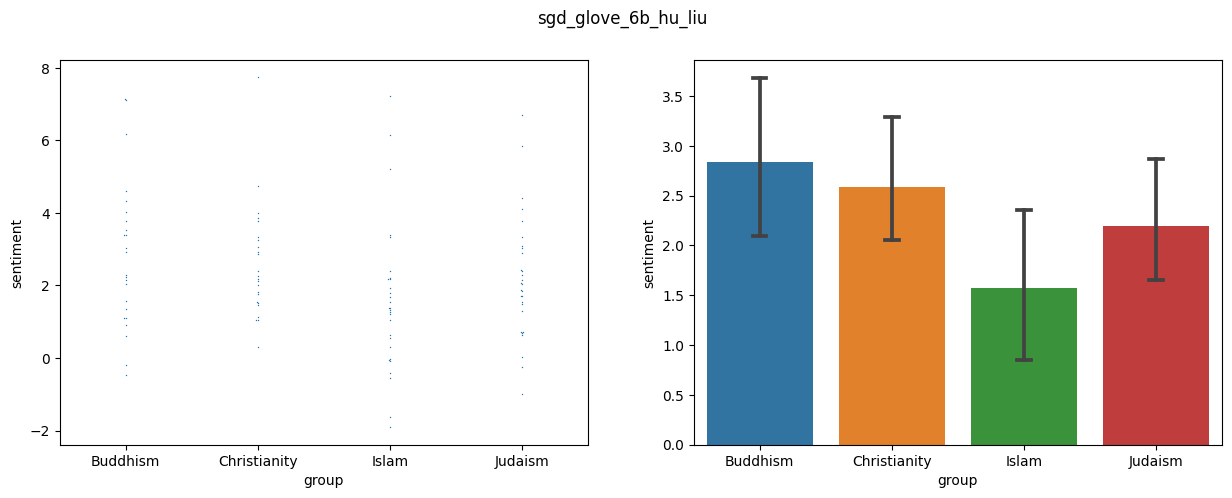

In [50]:
get_bias_stats('sgd_glove_6b_hu_liu', sgd_glove_6b_hu_liu_bias_test, test_religious_bias.keys())
plot_sentiment('sgd_glove_6b_hu_liu', sgd_glove_6b_hu_liu_bias_test, 1)

[ sgd_glove_840b_hu_liu ] - Fstatistic:  4.395348184648652  With P-value:  0.005960767710785126


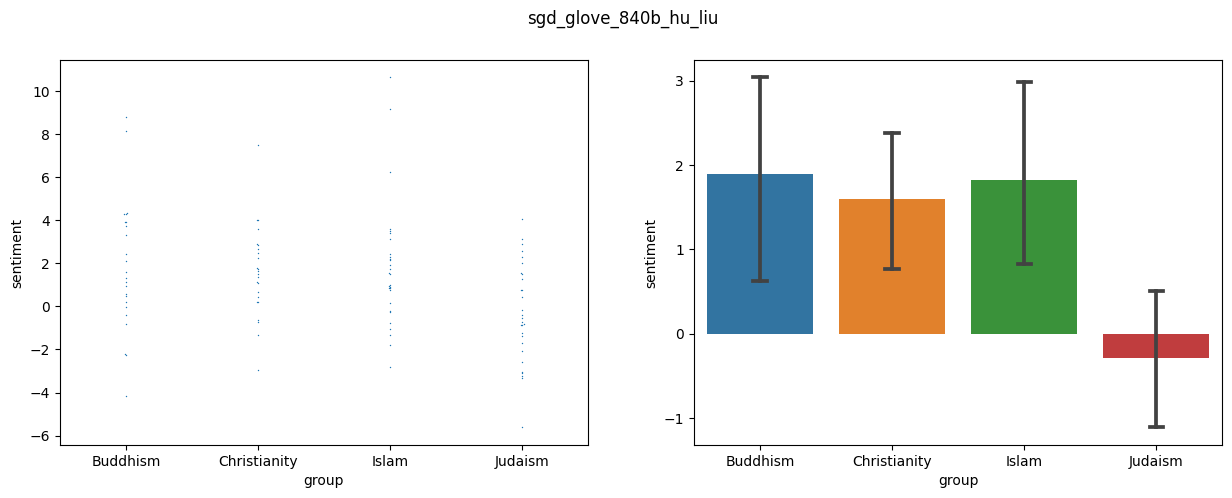

In [51]:
get_bias_stats('sgd_glove_840b_hu_liu', sgd_glove_840b_hu_liu_bias_test, test_religious_bias.keys())
plot_sentiment('sgd_glove_840b_hu_liu', sgd_glove_840b_hu_liu_bias_test, 1)

[ sgd_glove_w2v_hu_liu ] - Fstatistic:  4.195540119160182  With P-value:  0.007641289352684447


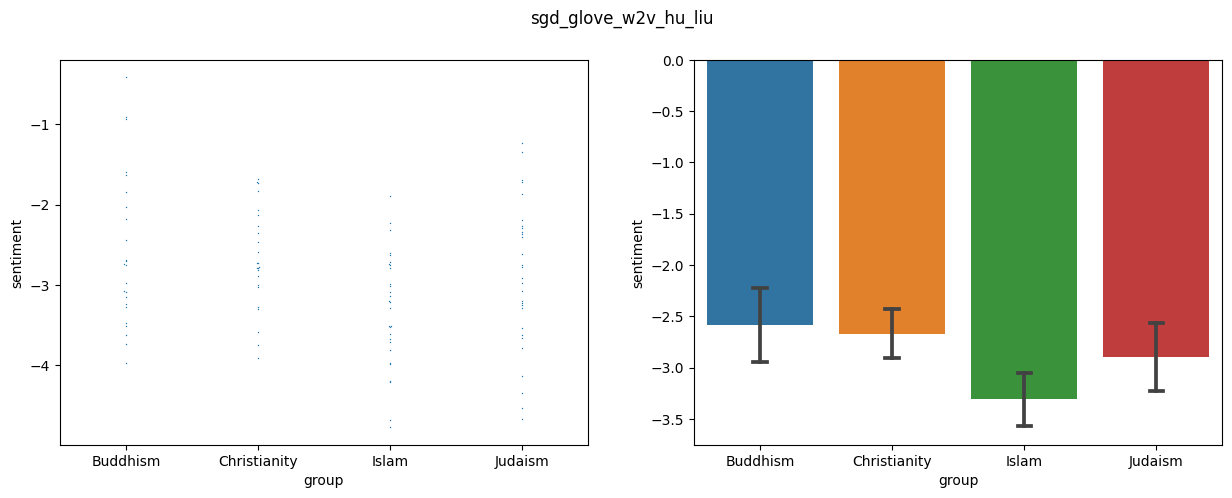

In [52]:
get_bias_stats('sgd_glove_w2v_hu_liu', sgd_glove_w2v_hu_liu_bias_test, test_religious_bias.keys())
plot_sentiment('sgd_glove_w2v_hu_liu', sgd_glove_w2v_hu_liu_bias_test, 1)

[ sgd_glove_numberbatch_hu_liu ] - Fstatistic:  5.084733970625883  With P-value:  0.0025424224169503826


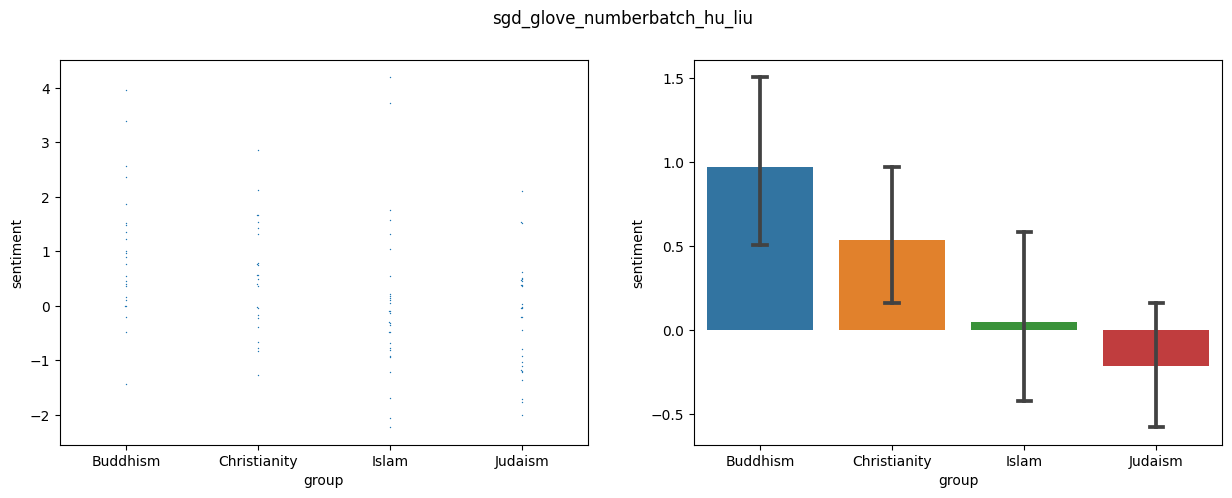

In [53]:
get_bias_stats('sgd_glove_numberbatch_hu_liu', sgd_glove_numberbatch_hu_liu_bias_test, test_religious_bias.keys())
plot_sentiment('sgd_glove_numberbatch_hu_liu', sgd_glove_numberbatch_hu_liu_bias_test, 1)

## CNN

Our sample convolutional neural network comprises of :
* Embedding Layer: translating sequense into dense representations of theentire sequence
* Consists of 3 filtering layers each one has 128 with kernel size of 5. 
  * With a kernel size of 5 that means it looks at 5 elements can be looked at simultaneously

In [54]:
def get_cnn_model(max_art_len, embedding_layer, num_classes):
    sequence_input = Input(shape=(max_art_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(filters= 128, kernel_size=5, activation='relu', kernel_initializer='he_uniform')(embedded_sequences)
    x = Dropout(rate= 0.05)(x)
    x = MaxPooling1D(pool_size = 5)(x) #Strides defaults to pooling size
    x = Dropout(rate= 0.15)(x)
    x = Conv1D(filters= 128, kernel_size= 5, activation='relu', kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(pool_size = 5)(x) #Strides defaults to pooling size
    x = Dropout(rate= 0.2)(x)
    x = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(pool_size = 35)(x) #Strides defaults to pooling size
    x = Flatten()(x)
    x = Dropout(rate= 0.25)(x)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

    preds = Dense(num_classes, activation='softmax',
                  kernel_initializer='glorot_uniform')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

In [55]:
embedding_layer_6b_300d = define_embedding_layer(
    300,
    glove_6B_300d_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_6B_300d
    MAX_ART_LEN
)

cnn_model_6B_300d = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_6b_300d,
    NUM_CLASSES
)

print(cnn_model_6B_300d.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         120000000 
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 dropout (Dropout)           (None, 996, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 199, 128)          0         
                                                             

In [56]:
embedding_layer_840b_300d = define_embedding_layer(
    300,
    glove_840B_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_840B_300d
    MAX_ART_LEN
)

cnn_model_840B = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_840b_300d, 
    NUM_CLASSES
)

print(cnn_model_840B.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 300)         658805100 
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_4 (Dropout)         (None, 996, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 199, 128)          0         
                                                           

In [57]:
embedding_layer_w2v = define_embedding_layer(
    300,
    w2v, #Use the entire w2v embedding and not the smaller version of vocab embedding_matrix_w2v
    MAX_ART_LEN
)

cnn_model_w2v = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_w2v, 
    NUM_CLASSES
)

print(cnn_model_w2v.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1000, 300)         532606200 
                                                                 
 conv1d_6 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_8 (Dropout)         (None, 996, 128)          0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 199, 128)          0         
                                                           

In [58]:
embedding_layer_numberbatch = define_embedding_layer(
    300,
    number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
    MAX_ART_LEN
)

cnn_model_numberbatch = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_numberbatch, 
    NUM_CLASSES
)

print(cnn_model_numberbatch.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1000, 300)         125424300 
                                                                 
 conv1d_9 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_12 (Dropout)        (None, 996, 128)          0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 199, 128)          0         
                                                           

In [59]:
cnn_histories_6b_300d = []
train_model(
    cnn_model_6B_300d, cnn_histories_6b_300d, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 17s 372ms/step - loss: 0.0103 - acc: 0.9952 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 16s 369ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [60]:
cnn_histories_840B = []
train_model(
    cnn_model_840B, cnn_histories_840B, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 17s 374ms/step - loss: 9.1962e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 15s 361ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [61]:
cnn_histories_w2v = []
train_model(
    cnn_model_w2v, cnn_histories_w2v, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 17s 368ms/step - loss: 0.0163 - acc: 0.9895 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 16s 372ms/step - loss: 1.4367e-05 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000


In [62]:
cnn_histories_numberbatch = []
train_model(
    cnn_model_numberbatch, cnn_histories_numberbatch, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 17s 376ms/step - loss: 0.0419 - acc: 0.9764 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 16s 362ms/step - loss: 3.0329e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000


In [63]:
result_6b_300d = test_bias(
    cnn_model_6B_300d,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [64]:
result_840b_300d = test_bias(
    cnn_model_840B,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [65]:
result_w2v = test_bias(
    cnn_model_w2v,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [66]:
result_numberbatch = test_bias(
    cnn_model_numberbatch,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


[ cnn_6b_300d ] - Fstatistic:  1.3020060756706475  With P-value:  0.2779250285930357


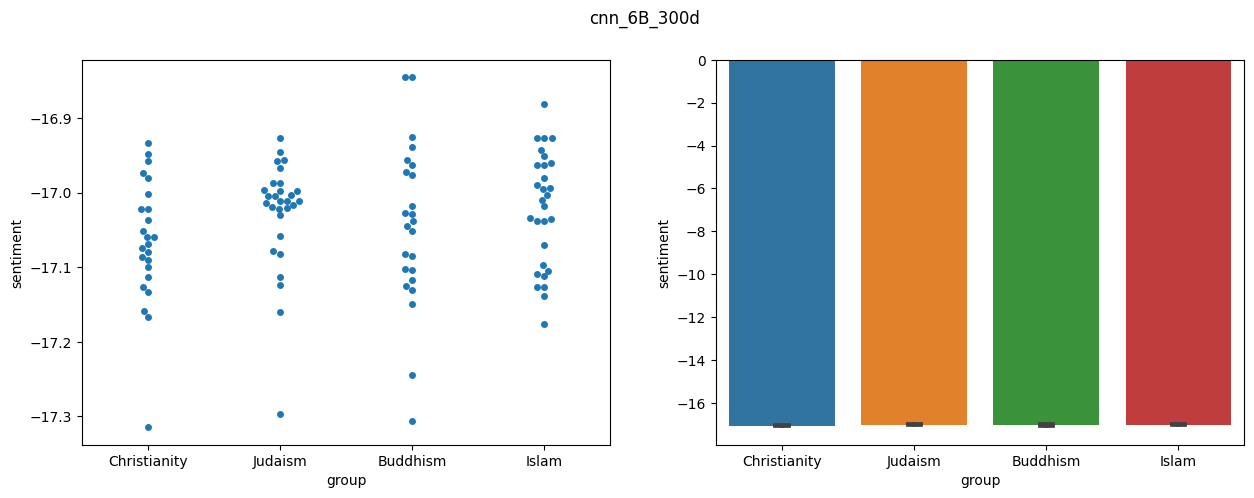

In [67]:
get_bias_stats('cnn_6b_300d', result_6b_300d, test_religious_bias.keys())
plot_sentiment('cnn_6B_300d', result_6b_300d)

[ cnn_840B_300d ] - Fstatistic:  1.1479362373333943  With P-value:  0.33350352797526284


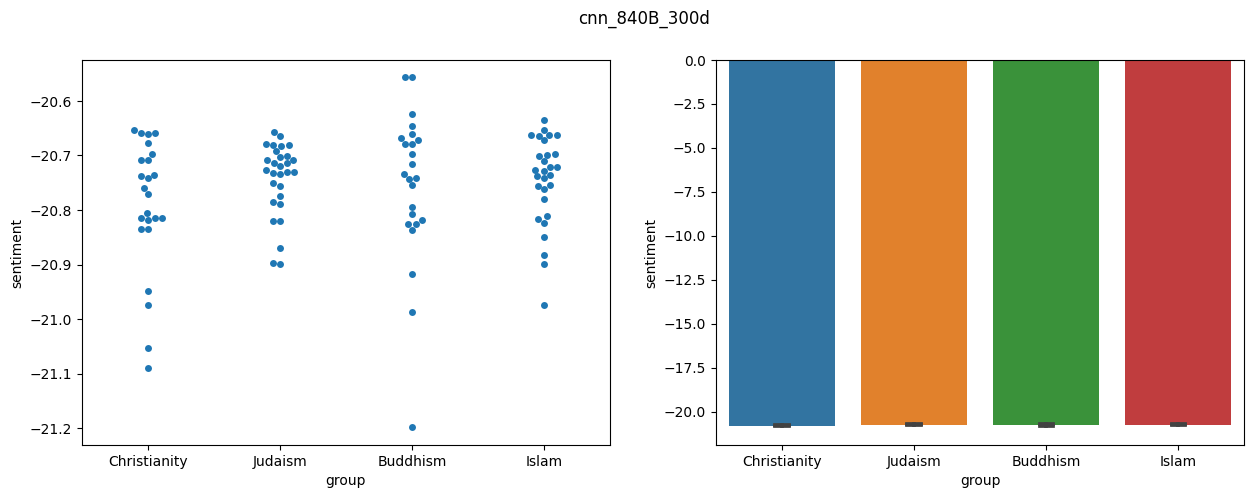

In [68]:
get_bias_stats('cnn_840B_300d', result_840b_300d, test_religious_bias.keys())
plot_sentiment('cnn_840B_300d', result_840b_300d)

[ cnn_w2v ] - Fstatistic:  2.6113383195232736  With P-value:  0.0554300225534646


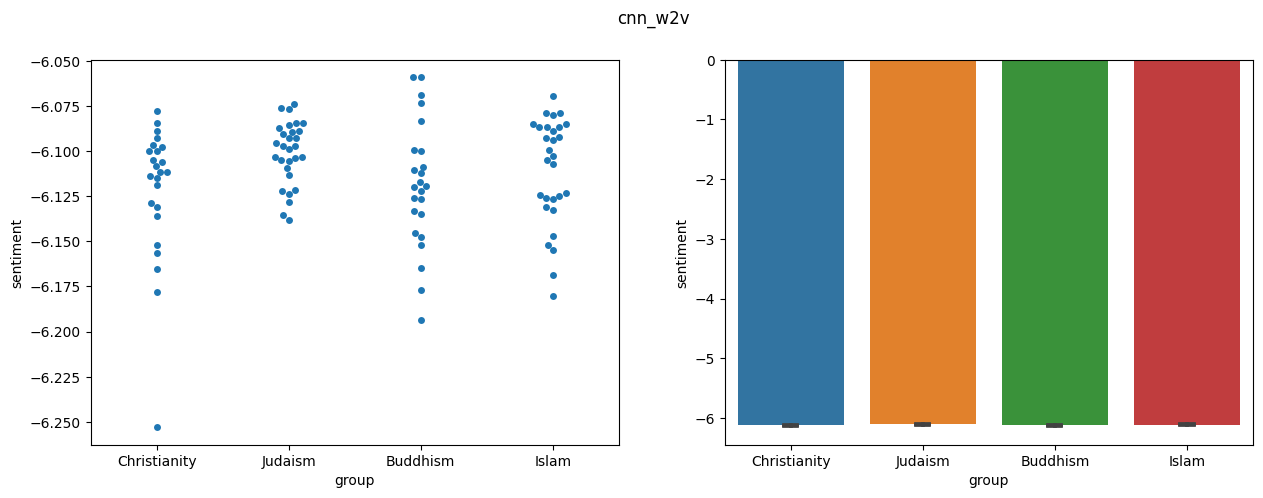

In [69]:
get_bias_stats('cnn_w2v', result_w2v, test_religious_bias.keys())
plot_sentiment('cnn_w2v', result_w2v)

[ cnn_numberbatch ] - Fstatistic:  2.22232062336958  With P-value:  0.0900778601711433


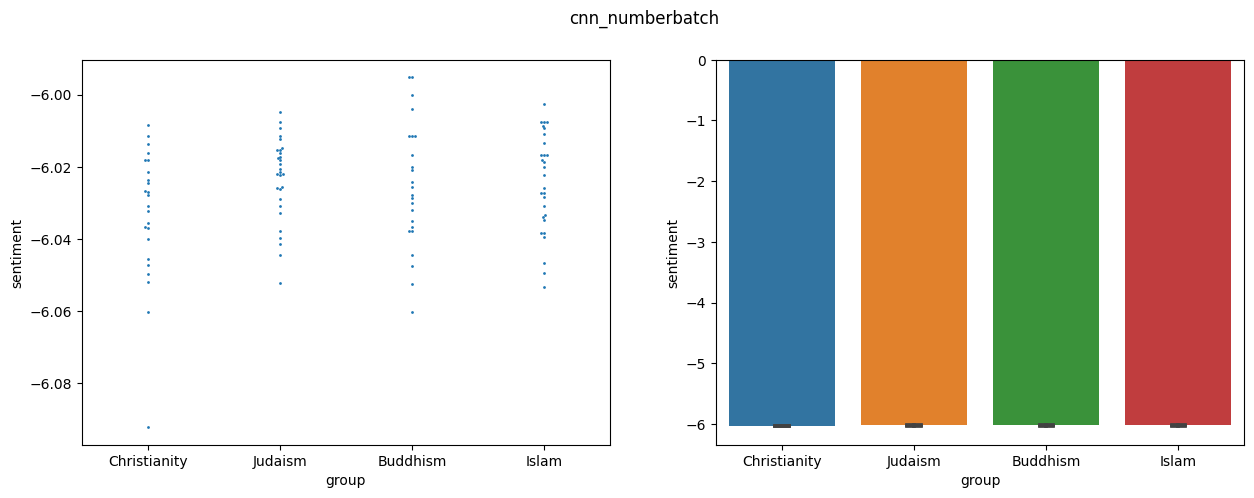

In [70]:
get_bias_stats('cnn_numberbatch', result_numberbatch, test_religious_bias.keys())
plot_sentiment('cnn_numberbatch', result_numberbatch, 2)

## RNN - LSTM

In [71]:
def get_lstm_model(max_art_len, embedding_layer, num_classes):
    lstm = Sequential()
    lstm.add(embedding_layer)
    lstm.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    lstm.add(Dense(num_classes, activation='sigmoid'))
    lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return lstm

In [72]:
lstm_model_6B_300d = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_6B_300d_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_6B_300d
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

print(lstm_model_6B_300d.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 300)         120000000 
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_8 (Dense)             (None, 2)                 202       
                                                                 
Total params: 120,160,602
Trainable params: 160,602
Non-trainable params: 120,000,000
_________________________________________________________________
None


In [73]:
lstm_model_840B_300d = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_840B_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_840B_300d
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

print(lstm_model_840B_300d.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 300)         658805100 
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 658,965,702
Trainable params: 160,602
Non-trainable params: 658,805,100
_________________________________________________________________
None


In [74]:
lstm_model_w2v = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        w2v, #Use the entire w2v embedding and not the smaller version of vocab embedding_matrix_w2v
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

print(lstm_model_w2v.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 300)         532606200 
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
Total params: 532,766,802
Trainable params: 160,602
Non-trainable params: 532,606,200
_________________________________________________________________
None


In [75]:
lstm_model_number_batch = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

print(lstm_model_number_batch.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1000, 300)         125424300 
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
Total params: 125,584,902
Trainable params: 160,602
Non-trainable params: 125,424,300
_________________________________________________________________
None


In [76]:
lstm_histories_6B = []
train_model(
    lstm_model_6B_300d, lstm_histories_6B, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 67s 1s/step - loss: 0.0294 - accuracy: 0.9764 - val_loss: 4.5649e-04 - val_accuracy: 1.0000
Epoch 2/2
43/43 [==============================] - 63s 1s/step - loss: 2.7626e-04 - accuracy: 1.0000 - val_loss: 1.1473e-04 - val_accuracy: 1.0000


In [77]:
lstm_histories_840B = []
train_model(
    lstm_model_840B_300d, lstm_histories_840B, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 66s 1s/step - loss: 0.0210 - accuracy: 0.9921 - val_loss: 4.4144e-04 - val_accuracy: 1.0000
Epoch 2/2
43/43 [==============================] - 64s 1s/step - loss: 2.6647e-04 - accuracy: 1.0000 - val_loss: 1.1257e-04 - val_accuracy: 1.0000


In [78]:
lstm_histories_w2v = []
train_model(
    lstm_model_w2v, lstm_histories_w2v, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 66s 2s/step - loss: 0.0298 - accuracy: 0.9785 - val_loss: 3.8029e-04 - val_accuracy: 1.0000
Epoch 2/2
43/43 [==============================] - 64s 1s/step - loss: 2.2642e-04 - accuracy: 1.0000 - val_loss: 1.0125e-04 - val_accuracy: 1.0000


In [79]:
lstm_histories_number_batch = []
train_model(
    lstm_model_number_batch, lstm_histories_number_batch, 
    pos_neg_lexicon_X_train, pos_neg_lexicon_y_train_ohe,
    pos_neg_lexicon_X_test, pos_neg_lexicon_y_test_ohe
)

Epoch 1/2
43/43 [==============================] - 66s 1s/step - loss: 0.0326 - accuracy: 0.9821 - val_loss: 3.0766e-04 - val_accuracy: 1.0000
Epoch 2/2
43/43 [==============================] - 64s 1s/step - loss: 1.8601e-04 - accuracy: 1.0000 - val_loss: 8.7000e-05 - val_accuracy: 1.0000


In [80]:
lstm_result_6b_300d = test_bias(
    lstm_model_6B_300d,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [81]:
lstm_result_840b_300d = test_bias(
    lstm_model_840B_300d,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [82]:
lstm_result_w2v = test_bias(
    lstm_model_w2v,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [83]:
lstm_result_number_batch = test_bias(
    lstm_model_number_batch,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


[ lstm_6B_300d ] - Fstatistic:  1.899714558307898  With P-value:  0.1343619641059144


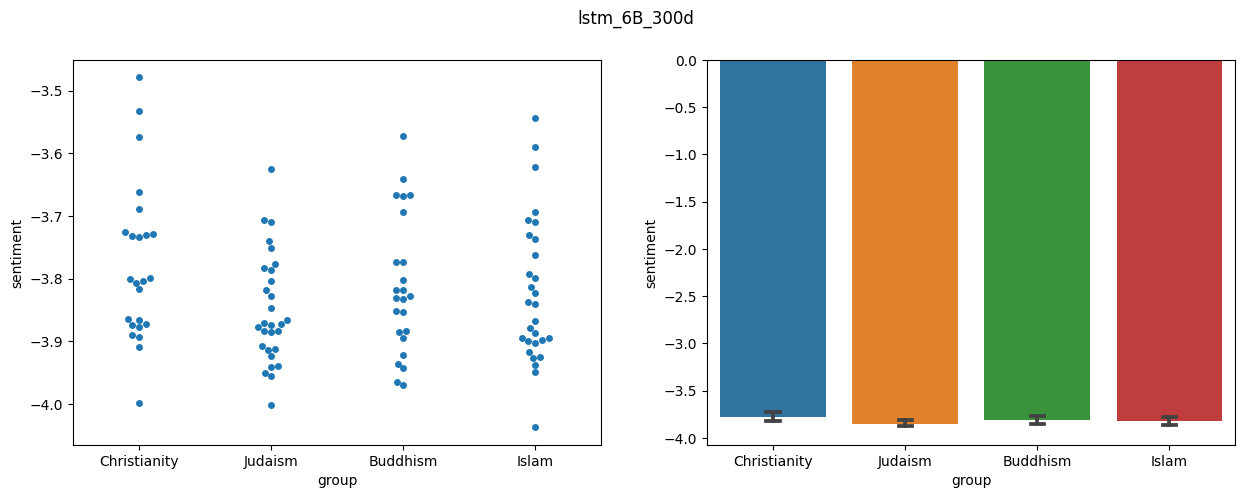

In [84]:
get_bias_stats('lstm_6B_300d', lstm_result_6b_300d, test_religious_bias.keys())
plot_sentiment('lstm_6B_300d', lstm_result_6b_300d)

[ lstm_840B_300d ] - Fstatistic:  1.881891415241259  With P-value:  0.13734807649398037


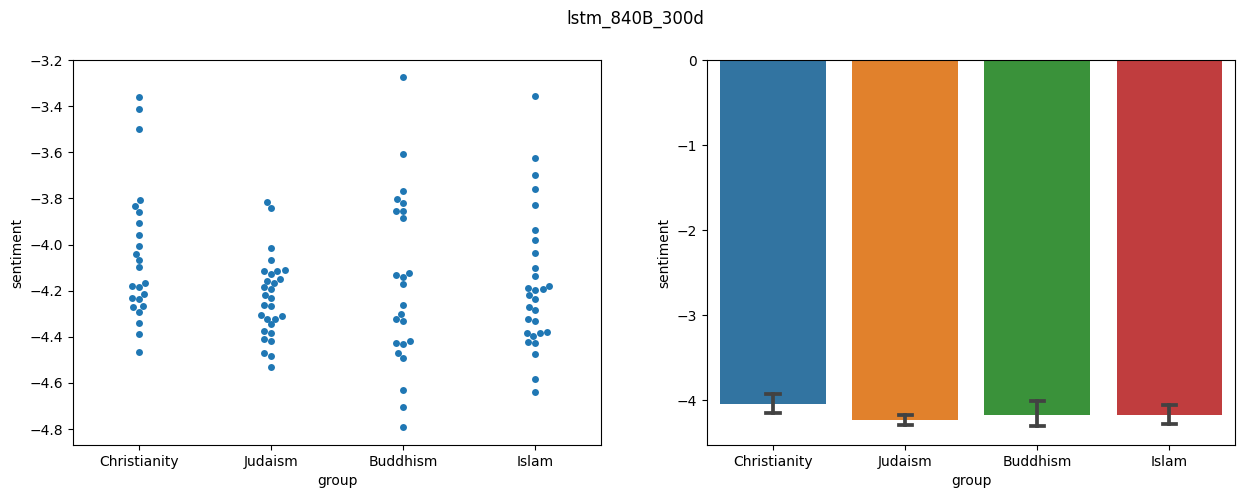

In [85]:
get_bias_stats('lstm_840B_300d', lstm_result_840b_300d, test_religious_bias.keys())
plot_sentiment('lstm_840B_300d', lstm_result_840b_300d)

[ lstm_w2v ] - Fstatistic:  1.1419922196462036  With P-value:  0.33583736873609626


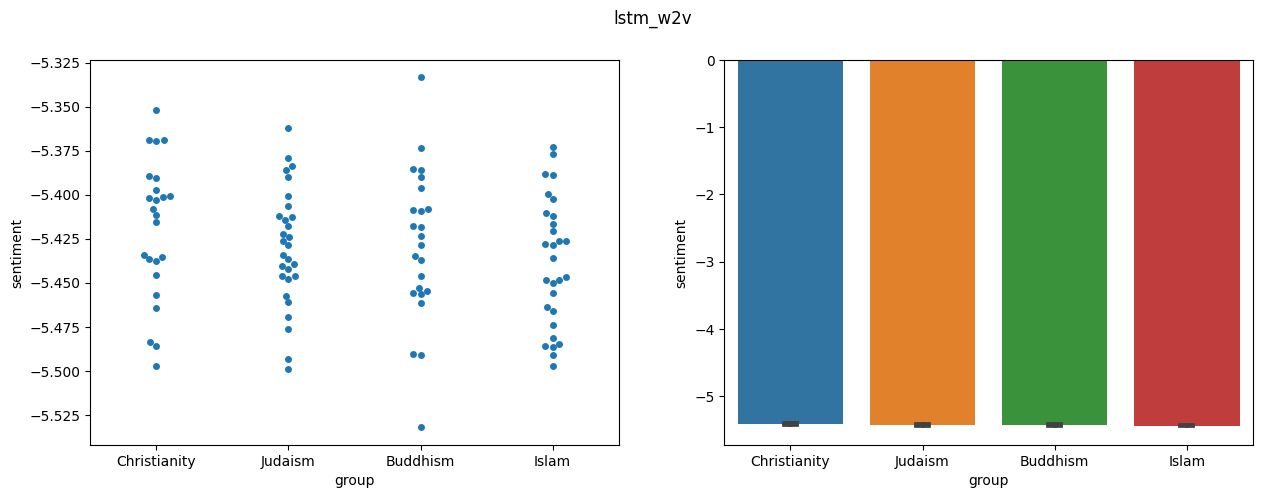

In [86]:
get_bias_stats('lstm_w2v', lstm_result_w2v, test_religious_bias.keys())
plot_sentiment('lstm_w2v', lstm_result_w2v)

[ lstm_number_batch ] - Fstatistic:  1.3414162808369887  With P-value:  0.2651482536228321


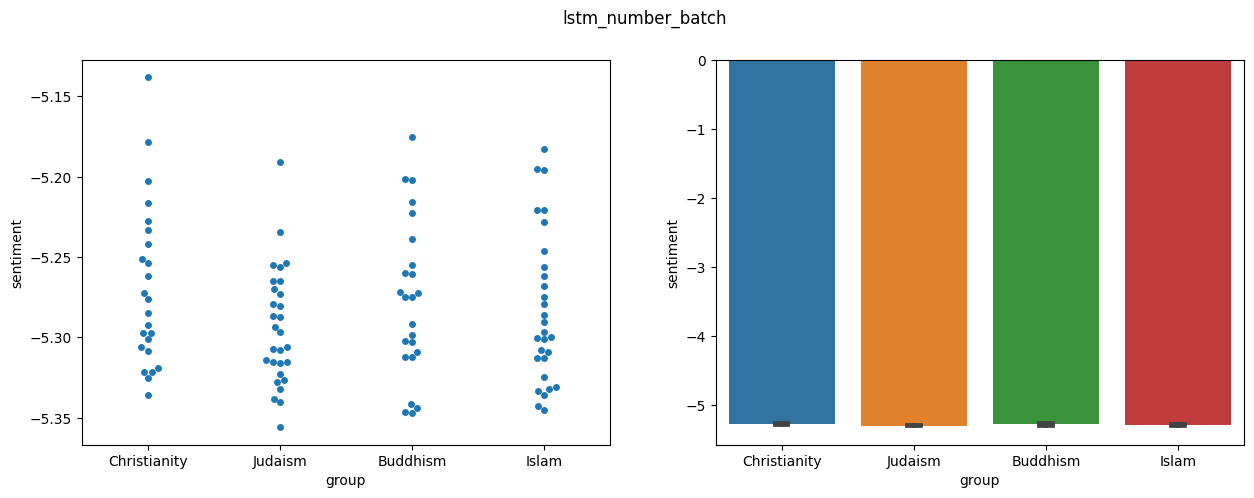

In [87]:
get_bias_stats('lstm_number_batch', lstm_result_number_batch, test_religious_bias.keys())
plot_sentiment('lstm_number_batch', lstm_result_number_batch)

# Training on Dense IMDB for sentiment analysis

## CNN

In [88]:
cnn_model_6B_300d_imdb = get_cnn_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_6B_300d_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_6B_300d
        MAX_ART_LEN
    ),
    NUM_CLASSES
)

# print(cnn_model_6B_300d_imdb.summary())

In [89]:
cnn_model_840B_300d_imdb = get_cnn_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_840B_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_840B_300d
        MAX_ART_LEN
    ),
    NUM_CLASSES
)

# print(cnn_model_6B_300d_imdb.summary())

In [90]:
cnn_model_w2v_imdb = get_cnn_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        w2v, #Use the entire w2v embedding and not the smaller version of vocab embedding_matrix_w2v
        MAX_ART_LEN
    ),
    NUM_CLASSES
)

# print(cnn_model_w2v_imdb.summary())

In [91]:
cnn_model_numberbatch_imdb = get_cnn_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
        MAX_ART_LEN
    ),
    NUM_CLASSES
)

# print(cnn_model_numberbatch_imdb.summary())

In [92]:
%%time
cnn_histories_6b_300d_imdb = []
train_model(
    cnn_model_6B_300d_imdb, cnn_histories_6b_300d_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    16
)

Epoch 1/16
196/196 [==============================] - 82s 417ms/step - loss: 0.7809 - acc: 0.5057 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 2/16
196/196 [==============================] - 80s 409ms/step - loss: 0.6875 - acc: 0.5472 - val_loss: 0.6766 - val_acc: 0.5667
Epoch 3/16
196/196 [==============================] - 82s 421ms/step - loss: 0.6454 - acc: 0.6296 - val_loss: 0.6874 - val_acc: 0.5975
Epoch 4/16
196/196 [==============================] - 82s 418ms/step - loss: 0.5840 - acc: 0.6893 - val_loss: 0.5727 - val_acc: 0.7192
Epoch 5/16
196/196 [==============================] - 82s 418ms/step - loss: 0.5380 - acc: 0.7333 - val_loss: 0.5517 - val_acc: 0.7462
Epoch 6/16
196/196 [==============================] - 81s 416ms/step - loss: 0.4955 - acc: 0.7646 - val_loss: 0.5500 - val_acc: 0.6999
Epoch 7/16
196/196 [==============================] - 81s 415ms/step - loss: 0.4570 - acc: 0.7931 - val_loss: 0.4823 - val_acc: 0.7755
Epoch 8/16
196/196 [==============================] - 8

In [93]:
%%time
cnn_histories_840b_300d_imdb = []
train_model(
    cnn_model_840B_300d_imdb, cnn_histories_840b_300d_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    16
)

Epoch 1/16
196/196 [==============================] - 84s 424ms/step - loss: 0.7354 - acc: 0.5108 - val_loss: 0.6894 - val_acc: 0.5616
Epoch 2/16
196/196 [==============================] - 82s 420ms/step - loss: 0.6764 - acc: 0.5817 - val_loss: 0.6523 - val_acc: 0.6141
Epoch 3/16
196/196 [==============================] - 82s 417ms/step - loss: 0.6360 - acc: 0.6434 - val_loss: 0.6437 - val_acc: 0.6051
Epoch 4/16
196/196 [==============================] - 82s 420ms/step - loss: 0.5853 - acc: 0.6921 - val_loss: 0.5759 - val_acc: 0.6798
Epoch 5/16
196/196 [==============================] - 83s 422ms/step - loss: 0.5365 - acc: 0.7316 - val_loss: 0.5836 - val_acc: 0.6587
Epoch 6/16
196/196 [==============================] - 81s 414ms/step - loss: 0.4866 - acc: 0.7714 - val_loss: 0.7758 - val_acc: 0.5836
Epoch 7/16
196/196 [==============================] - 81s 414ms/step - loss: 0.4414 - acc: 0.7946 - val_loss: 0.4734 - val_acc: 0.7681
Epoch 8/16
196/196 [==============================] - 8

In [94]:
%%time
cnn_histories_w2v_imdb = []
train_model(
    cnn_model_w2v_imdb, cnn_histories_w2v_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    16
)

Epoch 1/16
196/196 [==============================] - 83s 420ms/step - loss: 0.7169 - acc: 0.5056 - val_loss: 0.7169 - val_acc: 0.5000
Epoch 2/16
196/196 [==============================] - 81s 412ms/step - loss: 0.6807 - acc: 0.5735 - val_loss: 0.6410 - val_acc: 0.6450
Epoch 3/16
196/196 [==============================] - 81s 415ms/step - loss: 0.6292 - acc: 0.6506 - val_loss: 0.6227 - val_acc: 0.6343
Epoch 4/16
196/196 [==============================] - 82s 418ms/step - loss: 0.5509 - acc: 0.7236 - val_loss: 0.5529 - val_acc: 0.6999
Epoch 5/16
196/196 [==============================] - 80s 410ms/step - loss: 0.4706 - acc: 0.7773 - val_loss: 0.4575 - val_acc: 0.7785
Epoch 6/16
196/196 [==============================] - 81s 415ms/step - loss: 0.4011 - acc: 0.8195 - val_loss: 0.4202 - val_acc: 0.8038
Epoch 7/16
196/196 [==============================] - 82s 419ms/step - loss: 0.3404 - acc: 0.8530 - val_loss: 0.4225 - val_acc: 0.8102
Epoch 8/16
196/196 [==============================] - 8

In [95]:
%%time
cnn_histories_numberbatch_imdb = []
train_model(
    cnn_model_numberbatch_imdb, cnn_histories_numberbatch_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    16
)

Epoch 1/16
196/196 [==============================] - 82s 416ms/step - loss: 0.6977 - acc: 0.5199 - val_loss: 0.6702 - val_acc: 0.6045
Epoch 2/16
196/196 [==============================] - 80s 409ms/step - loss: 0.6463 - acc: 0.6278 - val_loss: 0.6114 - val_acc: 0.6551
Epoch 3/16
196/196 [==============================] - 81s 416ms/step - loss: 0.5700 - acc: 0.7073 - val_loss: 0.5387 - val_acc: 0.7294
Epoch 4/16
196/196 [==============================] - 81s 412ms/step - loss: 0.5175 - acc: 0.7451 - val_loss: 0.5054 - val_acc: 0.7452
Epoch 5/16
196/196 [==============================] - 80s 411ms/step - loss: 0.4696 - acc: 0.7770 - val_loss: 0.4538 - val_acc: 0.7956
Epoch 6/16
196/196 [==============================] - 80s 410ms/step - loss: 0.4183 - acc: 0.8093 - val_loss: 0.4308 - val_acc: 0.8020
Epoch 7/16
196/196 [==============================] - 81s 415ms/step - loss: 0.3747 - acc: 0.8357 - val_loss: 0.4907 - val_acc: 0.7611
Epoch 8/16
196/196 [==============================] - 8

In [96]:
cnn_result_6b_300d_imdb = test_bias(
    cnn_model_6B_300d_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [97]:
cnn_result_840b_300d_imdb = test_bias(
    cnn_model_840B_300d_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [98]:
cnn_result_w2v_imdb = test_bias(
    cnn_model_w2v_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [99]:
cnn_result_numberbatch_imdb = test_bias(
    cnn_model_numberbatch_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


[ cnn_6b_300d_imbdb ] - Fstatistic:  0.914010319136373  With P-value:  0.4370076697341807


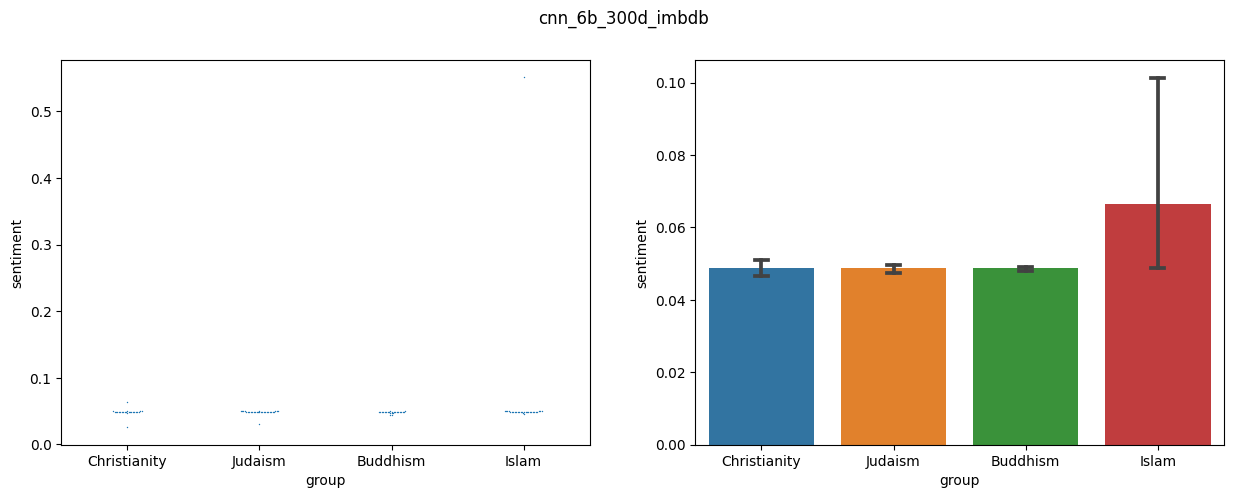

In [100]:
get_bias_stats('cnn_6b_300d_imbdb', cnn_result_6b_300d_imdb, test_religious_bias.keys())
plot_sentiment('cnn_6b_300d_imbdb', cnn_result_6b_300d_imdb, 1)

[ cnn_840b_300d_imbdb ] - Fstatistic:  0.8377645190390153  With P-value:  0.47620883862846797


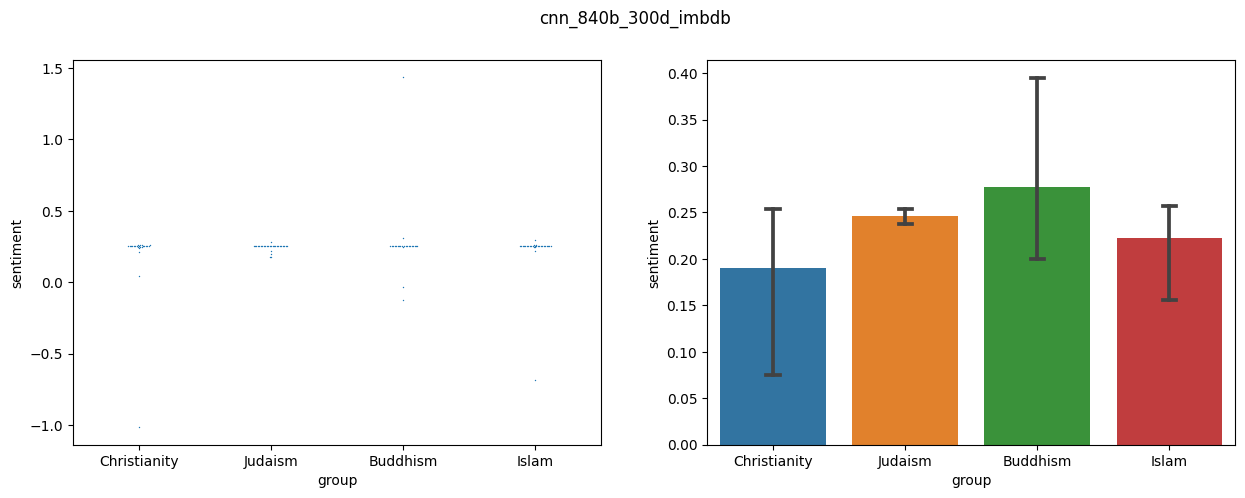

In [101]:
get_bias_stats('cnn_840b_300d_imbdb', cnn_result_840b_300d_imdb, test_religious_bias.keys())
plot_sentiment('cnn_840b_300d_imbdb', cnn_result_840b_300d_imdb, 1)

[ cnn_w2v_imbdb ] - Fstatistic:  1.1789160374500927  With P-value:  0.3215751184799034


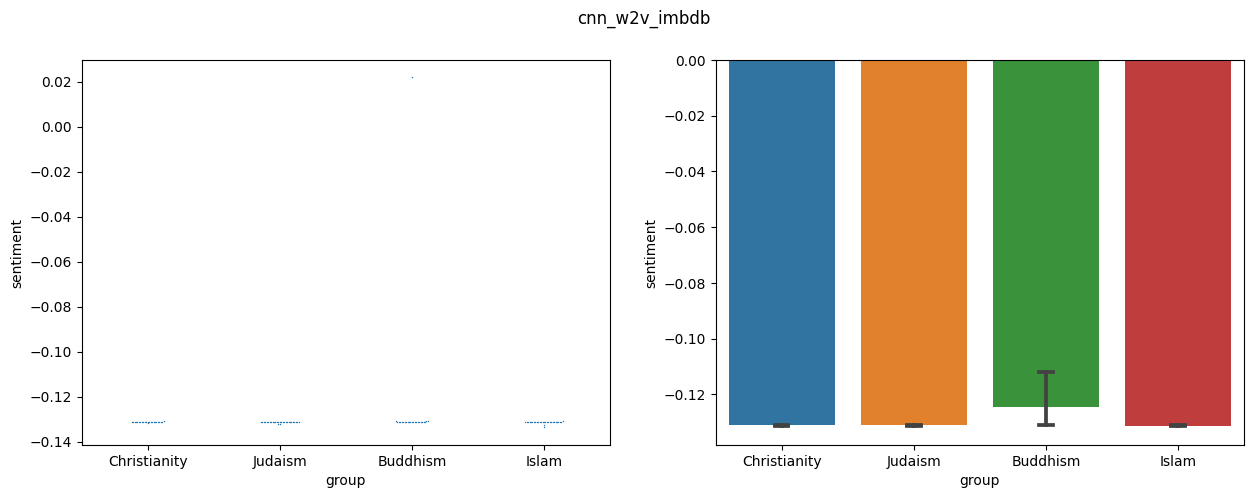

In [102]:
get_bias_stats('cnn_w2v_imbdb', cnn_result_w2v_imdb, test_religious_bias.keys())
plot_sentiment('cnn_w2v_imbdb', cnn_result_w2v_imdb, 1)

[ cnn_numberbatch_imbdb ] - Fstatistic:  0.8352606587594896  With P-value:  0.47754369265010643


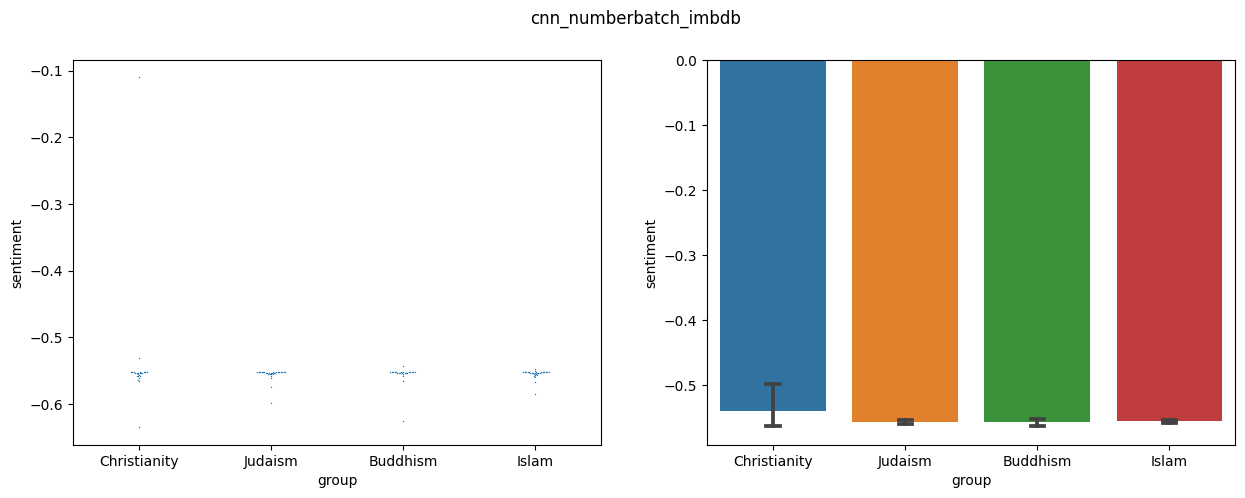

In [103]:
get_bias_stats('cnn_numberbatch_imbdb', cnn_result_numberbatch_imdb, test_religious_bias.keys())
plot_sentiment('cnn_numberbatch_imbdb', cnn_result_numberbatch_imdb, 1)

## RNN - LSTM

In [104]:
lstm_model_6B_300d_imdb = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_6B_300d_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_6B_300d
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

# print(lstm_model_6B_300d_imdb.summary())

In [105]:
lstm_model_840B_300d_imdb = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        glove_840B_embeddings, #Use the entire glove embedding and not the smaller version of vocab embedding_matrix_840B_300d
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

# print(lstm_model_6B_300d_imdb.summary())

In [106]:
lstm_model_w2v_imdb = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        w2v, #Use the entire w2v embedding and not the smaller version of vocab embedding_matrix_w2v
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

# print(lstm_model_6B_300d_imdb.summary())

In [107]:
lstm_model_numberbatch_imdb = get_lstm_model(
    MAX_ART_LEN, 
    define_embedding_layer(
        300,
        number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
        MAX_ART_LEN
    ), 
    NUM_CLASSES
)

# print(lstm_model_6B_300d_imdb.summary())

In [108]:
%%time
rnn_histories_6b_300d_imdb = []
train_model(
    lstm_model_6B_300d_imdb, rnn_histories_6b_300d_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    4
)

Epoch 1/4
196/196 [==============================] - 344s 2s/step - loss: 0.6617 - accuracy: 0.5958 - val_loss: 0.6360 - val_accuracy: 0.6257
Epoch 2/4
196/196 [==============================] - 347s 2s/step - loss: 0.6157 - accuracy: 0.6550 - val_loss: 0.5819 - val_accuracy: 0.6884
Epoch 3/4
196/196 [==============================] - 348s 2s/step - loss: 0.5859 - accuracy: 0.6823 - val_loss: 0.5522 - val_accuracy: 0.7160
Epoch 4/4
196/196 [==============================] - 348s 2s/step - loss: 0.5515 - accuracy: 0.7103 - val_loss: 0.6253 - val_accuracy: 0.6732
CPU times: user 2h 49min 55s, sys: 33min 55s, total: 3h 23min 50s
Wall time: 23min 8s


In [109]:
%%time
rnn_histories_840b_300d_imdb = []
train_model(
    lstm_model_840B_300d_imdb, rnn_histories_840b_300d_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    4
)

Epoch 1/4
196/196 [==============================] - 343s 2s/step - loss: 0.6583 - accuracy: 0.6004 - val_loss: 0.8801 - val_accuracy: 0.5080
Epoch 2/4
196/196 [==============================] - 342s 2s/step - loss: 0.6136 - accuracy: 0.6587 - val_loss: 0.6133 - val_accuracy: 0.6587
Epoch 3/4
196/196 [==============================] - 343s 2s/step - loss: 0.5939 - accuracy: 0.6762 - val_loss: 0.6442 - val_accuracy: 0.6236
Epoch 4/4
196/196 [==============================] - 345s 2s/step - loss: 0.5677 - accuracy: 0.7025 - val_loss: 0.5357 - val_accuracy: 0.7267
CPU times: user 2h 47min 50s, sys: 34min 17s, total: 3h 22min 8s
Wall time: 22min 53s


In [110]:
%%time
rnn_histories_w2v_imdb = []
train_model(
    lstm_model_w2v_imdb, rnn_histories_w2v_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    4
)

Epoch 1/4
196/196 [==============================] - 349s 2s/step - loss: 0.6696 - accuracy: 0.5840 - val_loss: 0.7007 - val_accuracy: 0.5517
Epoch 2/4
196/196 [==============================] - 344s 2s/step - loss: 0.6420 - accuracy: 0.6302 - val_loss: 0.6396 - val_accuracy: 0.6280
Epoch 3/4
196/196 [==============================] - 344s 2s/step - loss: 0.6254 - accuracy: 0.6500 - val_loss: 0.6151 - val_accuracy: 0.6592
Epoch 4/4
196/196 [==============================] - 343s 2s/step - loss: 0.6141 - accuracy: 0.6584 - val_loss: 0.6050 - val_accuracy: 0.6766
CPU times: user 2h 47min 20s, sys: 34min 39s, total: 3h 21min 59s
Wall time: 23min


In [111]:
%%time
rnn_histories_numberbatch_imdb = []
train_model(
    lstm_model_numberbatch_imdb, rnn_histories_numberbatch_imdb, 
    imdb_X_train, imdb_Y_train,
    imdb_X_test, imdb_Y_test,
    4
)

Epoch 1/4
196/196 [==============================] - 346s 2s/step - loss: 0.6727 - accuracy: 0.5865 - val_loss: 0.6185 - val_accuracy: 0.6644
Epoch 2/4
196/196 [==============================] - 359s 2s/step - loss: 0.6312 - accuracy: 0.6500 - val_loss: 0.6219 - val_accuracy: 0.6470
Epoch 3/4
196/196 [==============================] - 342s 2s/step - loss: 0.6113 - accuracy: 0.6687 - val_loss: 0.6282 - val_accuracy: 0.6386
Epoch 4/4
196/196 [==============================] - 343s 2s/step - loss: 0.5985 - accuracy: 0.6818 - val_loss: 0.6015 - val_accuracy: 0.6742
CPU times: user 2h 46min 48s, sys: 34min 38s, total: 3h 21min 26s
Wall time: 23min 10s


In [112]:
lstm_result_6b_300d_imdb = test_bias(
    lstm_model_6B_300d_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [113]:
lstm_result_840b_300d_imdb = test_bias(
    cnn_model_840B_300d_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [114]:
lstm_result_w2v_imdb = test_bias(
    lstm_model_w2v_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


In [115]:
lstm_result_numberbatch_imdb = test_bias(
    lstm_model_numberbatch_imdb,
    test_religious_bias,
    MAX_ART_LEN,
    NUM_TOP_WORDS
)

Found 72 unique tokens. Distilled to 72 top words.
Found 73 unique tokens. Distilled to 73 top words.
Found 75 unique tokens. Distilled to 75 top words.
Found 76 unique tokens. Distilled to 76 top words.


[ lstm_6b_300d_imbdb ] - Fstatistic:  0.21298664800721967  With P-value:  0.8871998976009488


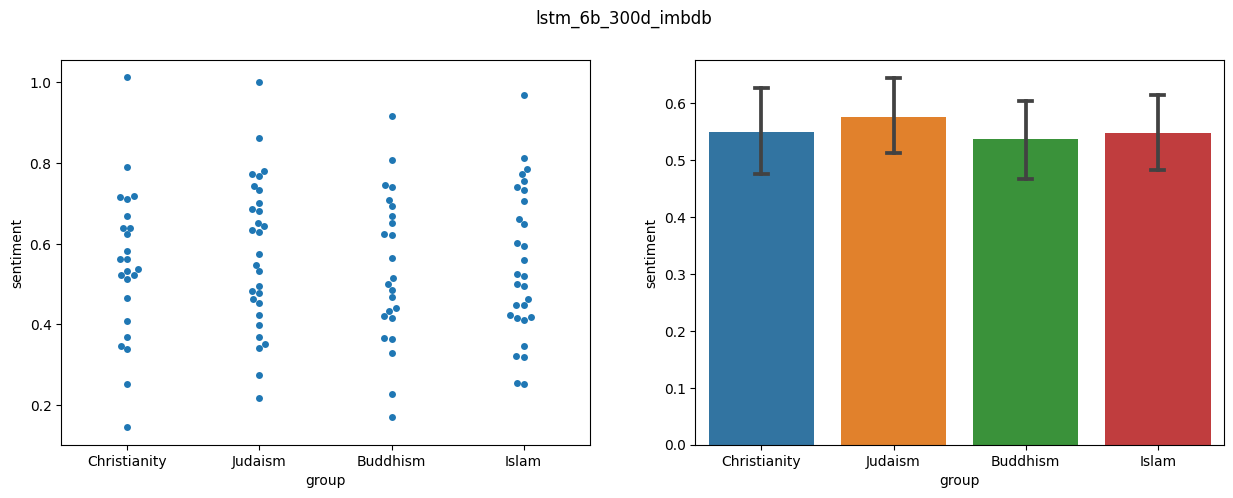

In [116]:
get_bias_stats('lstm_6b_300d_imbdb', lstm_result_6b_300d_imdb, test_religious_bias.keys())
plot_sentiment('lstm_6b_300d_imbdb', lstm_result_6b_300d_imdb)

[ lstm_840b_300d_imbdb ] - Fstatistic:  0.8377645190390153  With P-value:  0.47620883862846797


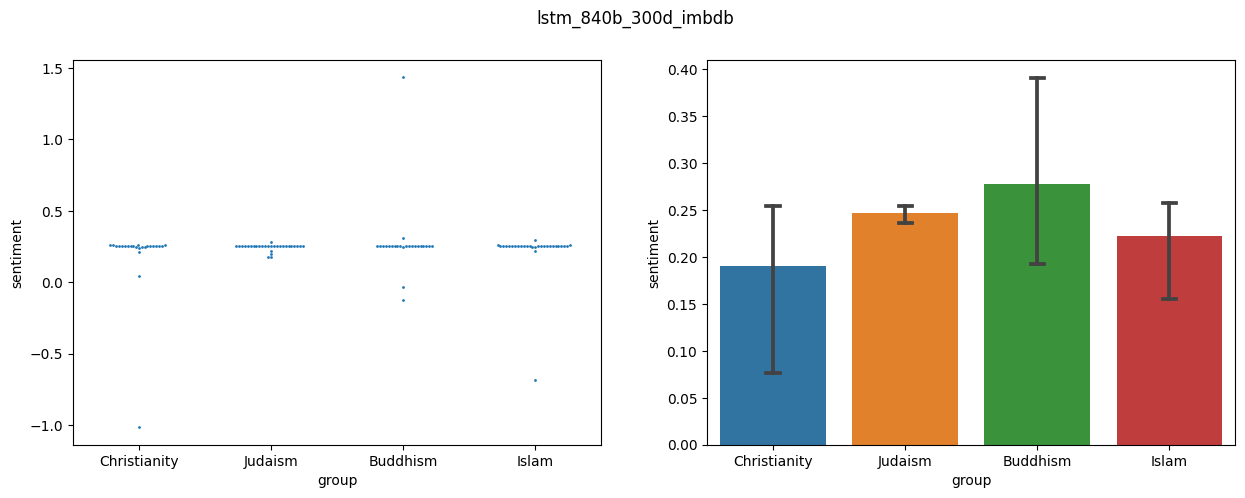

In [117]:
get_bias_stats('lstm_840b_300d_imbdb', lstm_result_840b_300d_imdb, test_religious_bias.keys())
plot_sentiment('lstm_840b_300d_imbdb', lstm_result_840b_300d_imdb, 2)

[ lstm_w2v_imbdb ] - Fstatistic:  0.2173545903759742  With P-value:  0.8841618797172209


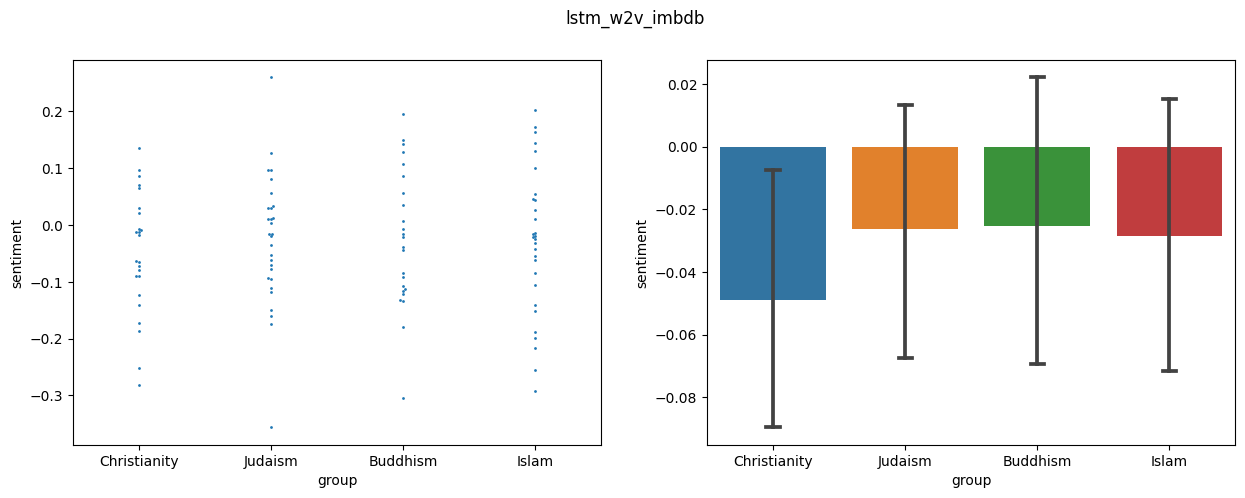

In [118]:
get_bias_stats('lstm_w2v_imbdb', lstm_result_w2v_imdb, test_religious_bias.keys())
plot_sentiment('lstm_w2v_imbdb', lstm_result_w2v_imdb, 2)

[ lstm_numberbatch_imbdb ] - Fstatistic:  0.2965292498301568  With P-value:  0.8278278178125805


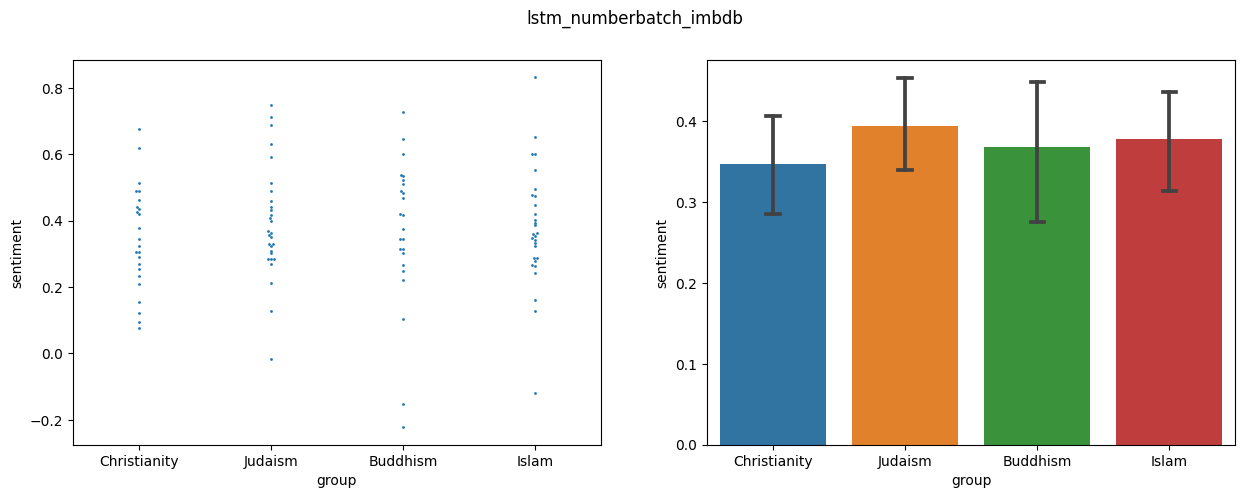

In [119]:
get_bias_stats('lstm_numberbatch_imbdb', lstm_result_numberbatch_imdb, test_religious_bias.keys())
plot_sentiment('lstm_numberbatch_imbdb', lstm_result_numberbatch_imdb, 2)

# Conclusion - Results 

## Plotting Helpers

In [125]:
from tabulate import tabulate

In [231]:
def hypothesis_1_plot():
    pyplot.figure(figsize=(30, 10))
    # cnn number batch lexicon
    ax = pyplot.subplot(2, 6, 1)
    ax.set_title("CNN_Lexicon")
    seaborn.swarmplot(x='group', y='sentiment', data=result_numberbatch, size=5)
    ax = pyplot.subplot(2, 6, 2)
    ax.set_title("CNN_Lexicon")
    seaborn.barplot(x='group', y='sentiment', data=result_numberbatch, capsize=.1)
    
    # rnn number batch lexicon
    ax = pyplot.subplot(2, 6, 3)
    ax.set_title("RNN_Lexicon")
    seaborn.swarmplot(x='group', y='sentiment', data=lstm_result_number_batch, size=5)
    ax = pyplot.subplot(2, 6, 4)
    ax.set_title("RNN_Lexicon")
    seaborn.barplot(x='group', y='sentiment', data=lstm_result_number_batch, capsize=.1)
    
    # sgd number batch lexicon
    ax = pyplot.subplot(2, 6, 5)
    ax.set_title("SGD_Lexicon")
    seaborn.swarmplot(x='group', y='sentiment', data=sgd_glove_numberbatch_hu_liu_bias_test, size=5)
    ax = pyplot.subplot(2, 6, 6)
    ax.set_title("SGD_Lexicon")
    seaborn.barplot(x='group', y='sentiment', data=sgd_glove_numberbatch_hu_liu_bias_test, capsize=.1)
    
    # cnn number batch imdb
    ax = pyplot.subplot(2, 6, 7)
    ax.set_title("CNN_IMDB")
    seaborn.swarmplot(x='group', y='sentiment', data=cnn_result_numberbatch_imdb, size=1)
    ax = pyplot.subplot(2, 6, 8)
    ax.set_title("CNN_IMDB")
    seaborn.barplot(x='group', y='sentiment', data=cnn_result_numberbatch_imdb, capsize=.1)
    
    # rnn number batch imdb
    ax = pyplot.subplot(2, 6, 9)
    ax.set_title("RNN_IMDB")
    seaborn.swarmplot(x='group', y='sentiment', data=lstm_result_numberbatch_imdb, size=5)
    ax = pyplot.subplot(2, 6, 10)
    ax.set_title("RNN_IMDB")
    seaborn.barplot(x='group', y='sentiment', data=lstm_result_numberbatch_imdb, capsize=.1)
    pyplot.suptitle("Number Batch Embedding Training")

In [249]:
def hypothesis_2_plot():
    pyplot.figure(figsize=(30, 10))
    
    # rnn number batch lexicon
    ax = pyplot.subplot(2, 4, 1)
    ax.set_title("RNN_Lexicon")
    seaborn.swarmplot(x='group', y='sentiment', data=lstm_result_number_batch, size=5)
    ax = pyplot.subplot(2, 4, 2)
    ax.set_title("RNN_Lexicon")
    seaborn.barplot(x='group', y='sentiment', data=lstm_result_number_batch, capsize=.1)
    
    # rnn number batch imdb
    ax = pyplot.subplot(2, 4, 3)
    ax.set_title("RNN_IMDB")
    seaborn.swarmplot(x='group', y='sentiment', data=lstm_result_numberbatch_imdb, size=5)
    ax = pyplot.subplot(2, 4, 4)
    ax.set_title("RNN_IMDB")
    seaborn.barplot(x='group', y='sentiment', data=lstm_result_numberbatch_imdb, capsize=.1)
    
    # cnn number batch lexicon
    ax = pyplot.subplot(2, 4, 5)
    ax.set_title("CNN_Lexicon")
    seaborn.swarmplot(x='group', y='sentiment', data=result_numberbatch, size=5)
    ax = pyplot.subplot(2, 4, 6)
    ax.set_title("CNN_Lexicon")
    seaborn.barplot(x='group', y='sentiment', data=result_numberbatch, capsize=.1)
    
    # cnn number batch imdb
    ax = pyplot.subplot(2, 4, 7)
    ax.set_title("CNN_IMDB")
    seaborn.swarmplot(x='group', y='sentiment', data=cnn_result_numberbatch_imdb, size=1)
    ax = pyplot.subplot(2, 4, 8)
    ax.set_title("CNN_IMDB")
    seaborn.barplot(x='group', y='sentiment', data=cnn_result_numberbatch_imdb, capsize=.1)

    pyplot.suptitle("Number Batch Embedding Training")

In [237]:
headers = ['Embedding - Sentiment Dataset', 'CNN', 'LSTM', 'SGD']
fstat_cnn_numberbatch_lexicon, pval_cnn_numberbatch_lexicon= get_bias_stats('cnn_numberbatch', result_numberbatch, test_religious_bias.keys(), False)
fstat_cnn_numberbatch_imdb, pval_cnn_numberbatch_imdb = get_bias_stats('cnn_numberbatch_imbdb', cnn_result_numberbatch_imdb, test_religious_bias.keys(), False)

fstat_rnn_numberbatch_lexicon, pval_rnn_numberbatch_lexicon = get_bias_stats('lstm_number_batch', lstm_result_number_batch, test_religious_bias.keys(), False)
fstat_rnn_numberbatch_imdb, pval_rnn_numberbatch_imdb = get_bias_stats('lstm_numberbatch_imbdb', lstm_result_numberbatch_imdb, test_religious_bias.keys(), False)

fstat_sgd_numberbatch_lexicon, pval_sgd_numberbatch_lexicon = \
    get_bias_stats('sgd_glove_numberbatch_hu_liu', sgd_glove_numberbatch_hu_liu_bias_test, test_religious_bias.keys(), False)

entries = [
    [
        'NumberBatch - Hu Liu Lexicon',
        "\n".join(["F-stat: " + str(fstat_cnn_numberbatch_lexicon), "P-Value: " + str(pval_cnn_numberbatch_lexicon)]),
        "\n".join(["F-stat: " + str(fstat_rnn_numberbatch_lexicon), "P-Value: " + str(pval_rnn_numberbatch_lexicon)]),
        "\n".join(["F-stat: " + str(fstat_sgd_numberbatch_lexicon), "P-Value: " + str(pval_sgd_numberbatch_lexicon)])
    ],
    [
        'NumberBatch - IMDB',
        "\n".join(["F-stat: " + str(fstat_cnn_numberbatch_imdb), "P-Value: " + str(pval_cnn_numberbatch_imdb)]),
        "\n".join(["F-stat: " + str(fstat_rnn_numberbatch_imdb), "P-Value: " + str(pval_rnn_numberbatch_imdb)]),
        "N/A"
    ]
]
table_hypothesis_1 = tabulate(entries, headers, "grid")

In [271]:
headers_2 = ['Model', 'Hu Liu Sparse Lexicon sentiment dataset', 'IMDB sentiment dataset', 'side notes']
entries_2 = [
    [
        'LSTM',
        "\n".join(["F-stat: " + str(fstat_rnn_numberbatch_lexicon), "P-Value: " + str(pval_rnn_numberbatch_lexicon)]),
        "\n".join(["F-stat: " + str(fstat_rnn_numberbatch_imdb), "P-Value: " + str(pval_rnn_numberbatch_imdb)]),
        "We can see that RNN trained on a sparse sentiment dataset doesn’t\npick up much context compared to when trained on the dense dataset.\n"+
        "* Box Plot - Generally more negative bias.\n"+
        "* P-Value for RNN-Sparse shows slightly more variation\nin comparison to the RNN - Dense P-Value."
    ],
    [
        'CNN',
        "\n".join(["F-stat: " + str(fstat_cnn_numberbatch_lexicon), "P-Value: " + str(pval_cnn_numberbatch_lexicon)]),
        "\n".join(["F-stat: " + str(fstat_cnn_numberbatch_imdb), "P-Value: " + str(pval_cnn_numberbatch_imdb)]),
        "We can see that CNN trained on a sparse sentiment dataset doesn’t\npick up much context compared to when trained on the dense dataset.\n"+
        "* Box Plot - Generally more negative bias.\n"+
        "* From the swarm plot we see more variation in sparse compared to the dense one.\n" +
        "Which is also being reflected on the p-value"
    ]
]
table_hypothesis_2 = tabulate(entries_2, headers_2, "grid")

## Hypothesis One
<a id='conclusions'></a>

<font color='blue'>**Hypothesis: Model architecture could mitigate the bias learnt.**</font>

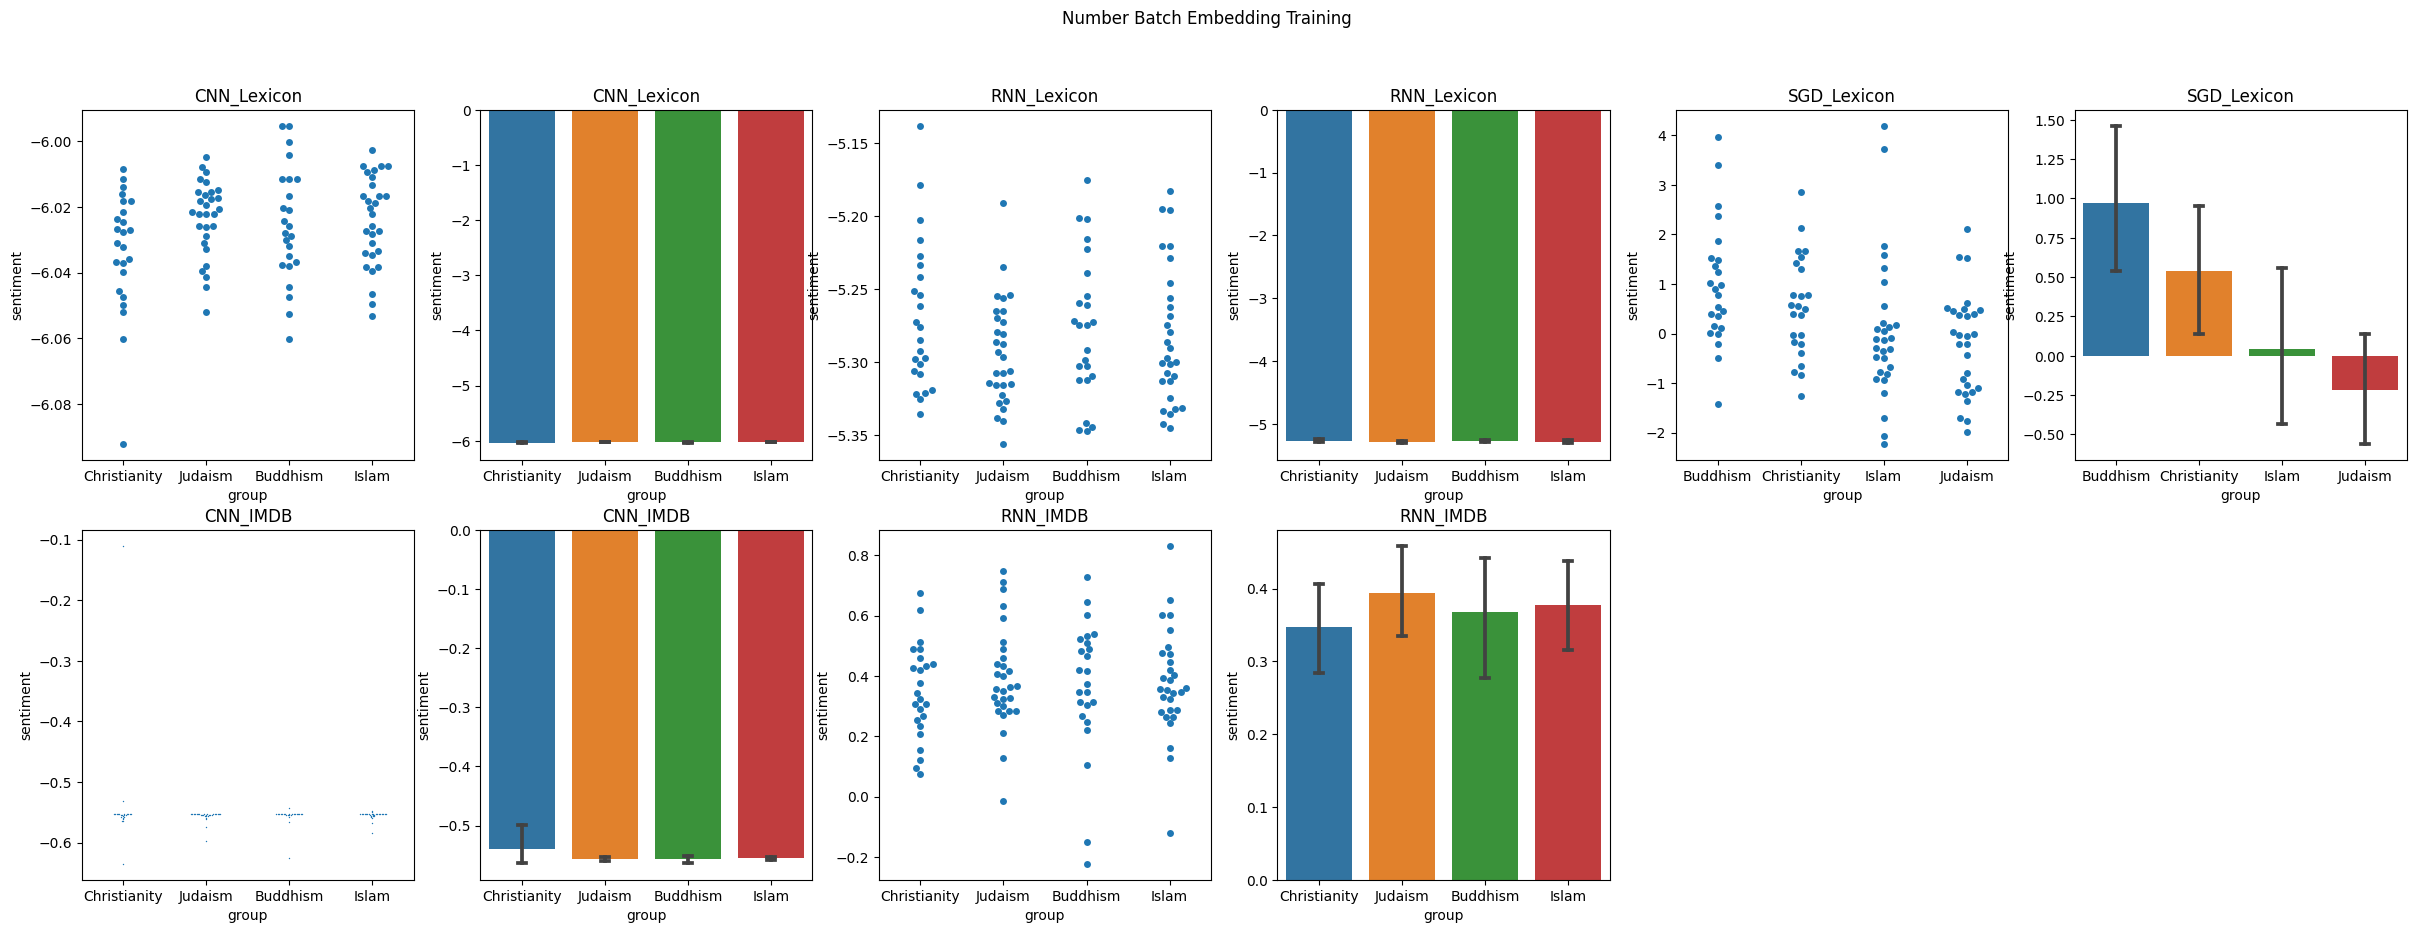

In [230]:
hypothesis_1_plot()

In [238]:
print(table_hypothesis_1)

+---------------------------------+------------------------------+-----------------------------+--------------------------------+
| Embedding - Sentiment Dataset   | CNN                          | LSTM                        | SGD                            |
+=================================+==============================+=============================+================================+
| NumberBatch - Hu Liu Lexicon    | F-stat: 2.22232062336958     | F-stat: 1.3414162808369887  | F-stat: 5.084733970625883      |
|                                 | P-Value: 0.0900778601711433  | P-Value: 0.2651482536228321 | P-Value: 0.0025424224169503826 |
+---------------------------------+------------------------------+-----------------------------+--------------------------------+
| NumberBatch - IMDB              | F-stat: 0.8352606587594896   | F-stat: 0.2965292498301568  | N/A                            |
|                                 | P-Value: 0.47754369265010643 | P-Value: 0.827827817812

<font color='blue'>In conclusion, we can see on comparing the f-stat and p-values for number batch on different models, LSTM with it’s consideration of abstract data representation(representing wider context instead of just individual word) announces less variation. (0.265 or 0.828 > threshold(0.05)). However, for SGD we can see the variation to almost be more significant(0.0003 < threshold(0.05)) of the p-value as an indication of more bias. As for CNN which learns patterns we can see there is a slight amount of variation (0.09 > threshold(0.05))  picked up compared to the P-value threshold(0.05). Thus, how a model learns the sentiment makes a lot of difference on how it picks up different biases.</font>

## Hypothesis Two: 

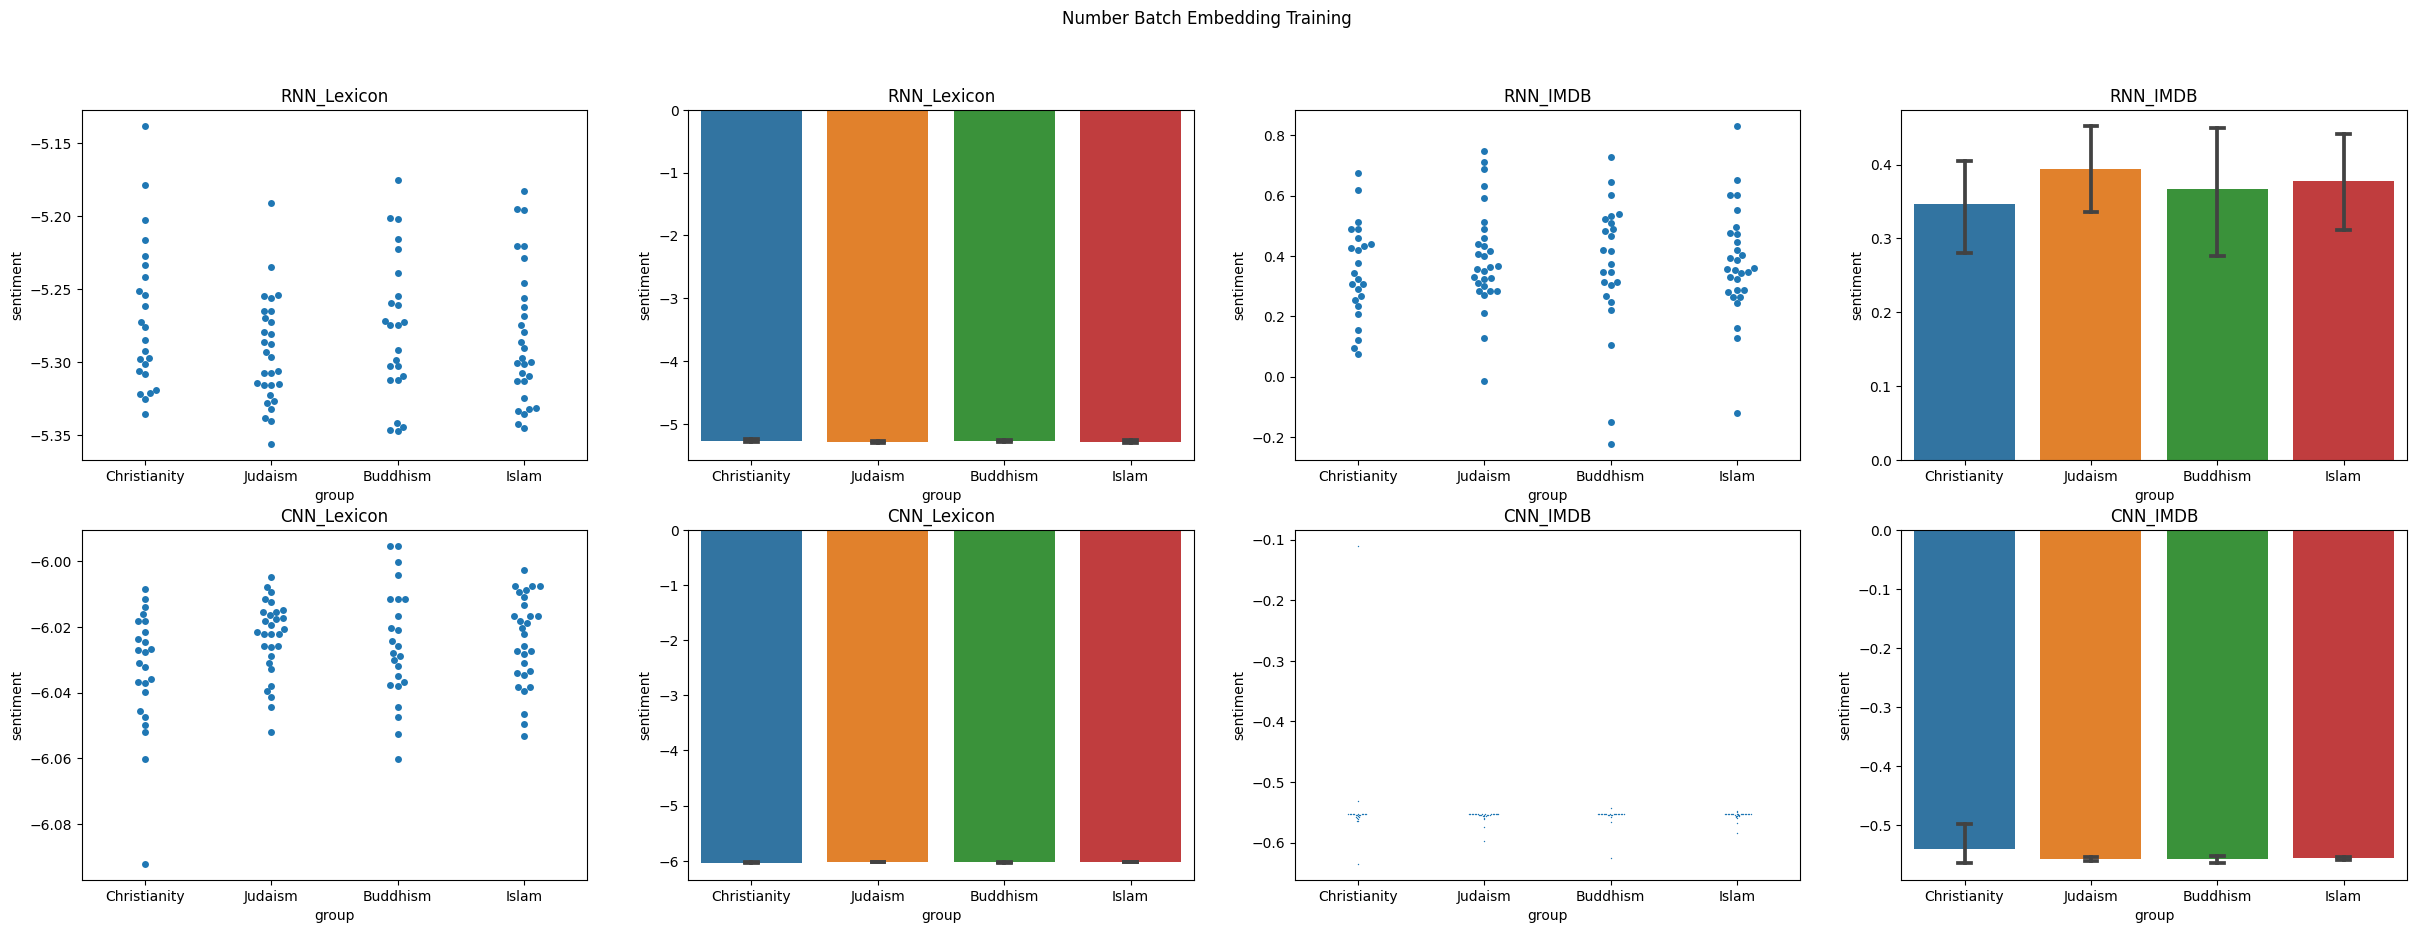

In [250]:
hypothesis_2_plot()

In [273]:
print(table_hypothesis_2)

+---------+-------------------------------------------+------------------------------+----------------------------------------------------------------------------------+
| Model   | Hu Liu Sparse Lexicon sentiment dataset   | IMDB sentiment dataset       | side notes                                                                       |
+=========+===========================================+==============================+==================================================================================+
| LSTM    | F-stat: 1.3414162808369887                | F-stat: 0.2965292498301568   | We can see that RNN trained on a sparse sentiment dataset doesn’t                |
|         | P-Value: 0.2651482536228321               | P-Value: 0.8278278178125805  | pick up much context compared to when trained on the dense dataset.              |
|         |                                           |                              | * Box Plot - Generally more negative bias.                     

<font color='blue'>Under the assumption of using an “improved biased” sentiment dataset. We can see that training neural networks (Taking context into consideration) on a dense sentiment dataset has an effect on the bias trend and variation. In our case for religious bias, we can say that using IMDB as a sentiment datasets resulted in less negative and less variation.</font>

# Conferences or Journals that would be interesetd in the results

* [Conference - The world’s leading AI summit for the Americas](https://americas.worldsummit.ai/)
* [Journal of Artificial Intelligence Research (JAIR)](https://www.jair.org/index.php/jair)